# Wasserstein GAN in Pytorch using LSUN Dataset

In [1]:
%matplotlib inline
import importlib

In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

In [3]:
import os, random

In [4]:
import matplotlib.pyplot as plt
import numpy as np

## Download and Process Dataset

Download the LSUN scene classification dataset bedroom category, unzip it, and convert it to JPG files (the scripts folder is here in the `dl2_2017` folder):

In [5]:
%mkdir ~/lsun_data

In [ ]:
!sudo apt install aria2 -y

In [11]:
!aria2c -x 10 -s 10 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -d ~/lsun_data

 *** Download Progress Summary as of Mon May 14 23:12:56 2018 ***              
[#2435e5 2.8GiB/42GiB(6%) CN:10 DL:49MiB ETA:13m39s]
FILE: /home/ubuntu/lsun_data/bedroom_train_lmdb.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon May 14 23:13:57 2018 ***              
[#2435e5 5.6GiB/42GiB(13%) CN:10 DL:44MiB ETA:14m10s]
FILE: /home/ubuntu/lsun_data/bedroom_train_lmdb.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon May 14 23:14:57 2018 ***              
[#2435e5 8.6GiB/42GiB(20%) CN:10 DL:53MiB ETA:10m46s]
FILE: /home/ubuntu/lsun_data/bedroom_train_lmdb.zip
-------------------------------------------------------------------------------

 *** Download Progress Summary as of Mon May 14 23:15:57 2018 ***              
[#2435e5 11GiB/42GiB(27%) CN:10 DL:59MiB ETA:8m47s]
FILE: /home/ubuntu/lsun_data/bedroom_train_lmdb.zip
----------------

In [ ]:
#!curl 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -o ~/lsun_data/bedroom_train_lmdb.zip

In [4]:
!ls -lh ~/lsun_data

total 43G
-rw-rw-r-- 1 ubuntu ubuntu 43G May 14 23:26 bedroom_train_lmdb.zip


In [ ]:
!unzip ~/lsun_data/bedroom_train_lmdb.zip

In [6]:
!ls -lh

total 1.6M
drwxrwxr-x 3 ubuntu ubuntu 4.0K May 15 06:31 data
-rw-rw-r-- 1 ubuntu ubuntu 122K May 14 15:29 DCGAN.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 2.9K May 14 15:29 dcgan.py
-rw-rw-r-- 1 ubuntu ubuntu  16K May 14 23:00 Get System Info.ipynb
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 14 15:29 lsun_scripts
-rw-rw-r-- 1 ubuntu ubuntu 8.1K May 14 15:29 normalization_mode2.py
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 14 23:00 __pycache__
-rw-rw-r-- 1 ubuntu ubuntu 286K May 14 15:29 pytorch-tut.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 1.3K May 14 15:29 torch_utils.py
-rw-rw-r-- 1 ubuntu ubuntu 4.6K May 14 15:29 utils2.py
-rw-rw-r-- 1 ubuntu ubuntu 1.1M May 14 15:29 wgan-pytorch.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  30K May 14 23:26 wgan-pytorch-lsun-dataset.ipynb
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 15 06:20 wgan_samples


The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [5]:
bs, sz, nz = 64, 64, 100 # nz is the size of the latent z vector

In [6]:
# My custom codes
# Where to store samples and models
experiment_path = 'wgan_samples'

In [ ]:
os.system('mkdir {0}'.format(experiment_path))

In [7]:
# Fix seed
manual_seed = random.randint(1, 10000)
print(manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

1649


In [8]:
cudnn.benchmark = True

Pytorch has the handy [torch-vision](https://github.com/pytorch/vision) library which makes handling images fast and easy.

Install LMDB package for processing LSUN datasets.

In [10]:
!pip install lmdb

    100% |████████████████████████████████| 4.0MB 167kB/s ta 0:00:01
  Running setup.py bdist_wheel for lmdb ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/57/40/51/3fe10a4a559a91352579a27cbcca490f279bacb54209713c4b
Successfully built lmdb
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
PATH = 'data/'
data = datasets.LSUN(root=PATH, classes=['bedroom_train'],
    transform=transforms.Compose([
        transforms.Scale(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Even parallel processing is handling automatically by torch-vision.

In [10]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader)
n

47392

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [11]:
def show(img, fs=(6,6)):
    plt.figure(figsize=fs)
    plt.imshow(np.transpose((img / 2 + 0.5).clamp(0, 1).numpy(), (1, 2, 0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [12]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [13]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [14]:
# nc is input image channels = 3
# ngf is number of generator filter = 64
# ngpu is number of GPUs to use = 1
# n_extra_layers is number of extra layers on gen and disc = 1
netG = DCGAN_G(sz, nz, 3, 64, 1, 1).cuda()
netG.apply(weights_init)

DCGAN_G(
  (main): Sequential(
    (initial-100.512.convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial-512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial-512.relu): ReLU(inplace)
    (pyramid-512.256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): ReLU(inplace)
    (pyramid-256.128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): ReLU(inplace)
    (pyramid-128.64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-64.relu): ReLU(inplace)
    (extra-0-64.64.convt): Con

In [15]:
netD = DCGAN_D(sz, 3, 64, 1, 1).cuda()
netD.apply(weights_init)

DCGAN_D(
  (main): Sequential(
    (initial-3.64.conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (initial-64.relu): LeakyReLU(0.2, inplace)
    (extra-0-64.64.conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (extra-0-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (extra-0-64.relu): LeakyReLU(0.2, inplace)
    (pyramid-64.128.conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): LeakyReLU(0.2, inplace)
    (pyramid-128.256.conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): LeakyReLU(0.2, inplace)
    (pyramid-256.512.conv):

Just some shortcuts to create tensors and variables.

### Continue Training (custom codes)

In [16]:
netG_checkpoint = experiment_path + '/netG_epoch_1.pth'
netD_checkpoint = experiment_path + '/netD_epoch_1.pth'

# set path to netG_checkpoint (to continue training)
netG_model = netG_checkpoint
netD_model = netD_checkpoint

if netG_model != '':
    netG.load_state_dict(torch.load(netG_model))
    print('continue training generator/actor')

if netD_model != '':
    netD.load_state_dict(torch.load(netD_model))
    print('continue training discriminator/critic')

continue training generator/actor
continue training discriminator/critic


In [17]:
from torch import FloatTensor as FT

In [18]:
def Var(*params):
    return Variable( FT(*params).cuda() )

In [19]:
def create_noise(b): 
    return Variable( FT(b, nz, 1, 1).cuda().normal_(0, 1) )

In [20]:
# Input placeholder
input = Var(bs, 3, sz, nz)

# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)

# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [21]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [22]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [23]:
def make_trainable(net, val):
    for p in net.parameters(): # reset requires_grad
        p.requires_grad = val # they are set to False below in netG update

In [26]:
def train(niter, first=True):
    
    gen_iterations = 0
    
    for epoch in range(niter):
        data_iter = iter(dataloader)
        i = 0
        
        while i < n:
            ###########################
            # (1) Update D network
            ###########################
            make_trainable(netD, True)
            
            # train the discriminator d_iters times
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5) # 5 is number of D iters per each G iter

            j = 0
            
            while j < d_iters and i < n:
                j += 1
                i += 1
                
                # clamp parameters to a cube
                for p in netD.parameters():
                    p.data.clamp_(-0.01, 0.01)

                # my own codes
                data = next(data_iter)
                
                # train with real
                real_cpu, _ = data # my own codes
                real_cpu = real_cpu.cuda() # my own codes
                real = Variable( data[0].cuda() )
                netD.zero_grad()
                errD_real = step_D(real, one)

                # train with fake
                fake = netG( create_noise(real.size()[0]) )
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            ###########################
            # (2) Update G network
            ###########################
            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
                % (epoch, niter, i, n, gen_iterations,
                errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

            if gen_iterations % 500 == 0: # every 500 generator iterations
                print('saving real and fake images...')
                real_cpu = real_cpu.mul(0.5).add(0.5)
                vutils.save_image(real_cpu, '{0}/real_samples.png'.format(experiment_path))
                fake = netG(create_noise(bs)) # create_noise replaced these codes: Variable(fixed_noise, volatile=True)
                fake.data = fake.data.mul(0.5).add(0.5)
                vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(experiment_path, gen_iterations))
        
                # do checkpointing
                torch.save(netG.state_dict(), '{0}/netG_epoch_{1}_geniter_{2}.pth'.format(experiment_path, epoch, gen_iterations))
                torch.save(netD.state_dict(), '{0}/netD_epoch_{1}_geniter_{2}.pth'.format(experiment_path, epoch, gen_iterations))
                
        # do checkpointing
        torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment_path, epoch))
        torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment_path, epoch))

In [ ]:
%time train(2, True)

[0/2][100/47392][1] Loss_D: -1.290255 Loss_G: 0.540855 Loss_D_real: -0.652733 Loss_D_fake 0.637522
[0/2][200/47392][2] Loss_D: -1.329199 Loss_G: 0.631982 Loss_D_real: -0.651422 Loss_D_fake 0.677776
[0/2][300/47392][3] Loss_D: -1.399799 Loss_G: 0.697919 Loss_D_real: -0.706409 Loss_D_fake 0.693390
[0/2][400/47392][4] Loss_D: -1.325793 Loss_G: 0.646425 Loss_D_real: -0.667544 Loss_D_fake 0.658249
[0/2][500/47392][5] Loss_D: -1.012025 Loss_G: 0.569396 Loss_D_real: -0.642279 Loss_D_fake 0.369747
[0/2][600/47392][6] Loss_D: -1.361122 Loss_G: 0.700084 Loss_D_real: -0.696951 Loss_D_fake 0.664171
[0/2][700/47392][7] Loss_D: -1.257493 Loss_G: 0.646639 Loss_D_real: -0.673455 Loss_D_fake 0.584038
[0/2][800/47392][8] Loss_D: -1.202193 Loss_G: 0.602229 Loss_D_real: -0.618507 Loss_D_fake 0.583686
[0/2][900/47392][9] Loss_D: -1.342588 Loss_G: 0.622350 Loss_D_real: -0.669433 Loss_D_fake 0.673155
[0/2][1000/47392][10] Loss_D: -1.153753 Loss_G: 0.628768 Loss_D_real: -0.664647 Loss_D_fake 0.489107
[0/2][11

[0/2][2785/47392][82] Loss_D: -0.133035 Loss_G: -0.332811 Loss_D_real: 0.229696 Loss_D_fake 0.362731
[0/2][2790/47392][83] Loss_D: -0.111504 Loss_G: 0.024404 Loss_D_real: -0.141190 Loss_D_fake -0.029686
[0/2][2795/47392][84] Loss_D: -0.136692 Loss_G: -0.290526 Loss_D_real: -0.065302 Loss_D_fake 0.071390
[0/2][2800/47392][85] Loss_D: -0.113263 Loss_G: 0.243427 Loss_D_real: -0.201501 Loss_D_fake -0.088239
[0/2][2805/47392][86] Loss_D: -0.193233 Loss_G: -0.415153 Loss_D_real: 0.054996 Loss_D_fake 0.248228
[0/2][2810/47392][87] Loss_D: -0.154890 Loss_G: -0.216374 Loss_D_real: 0.166440 Loss_D_fake 0.321329
[0/2][2815/47392][88] Loss_D: -0.203791 Loss_G: 0.280870 Loss_D_real: -0.137471 Loss_D_fake 0.066320
[0/2][2820/47392][89] Loss_D: -0.021605 Loss_G: -0.201217 Loss_D_real: -0.113864 Loss_D_fake -0.092259
[0/2][2825/47392][90] Loss_D: -0.151445 Loss_G: -0.057078 Loss_D_real: 0.204646 Loss_D_fake 0.356092
[0/2][2830/47392][91] Loss_D: -0.070232 Loss_G: -0.066623 Loss_D_real: 0.034371 Loss_D

[0/2][3190/47392][163] Loss_D: -0.110826 Loss_G: 0.332915 Loss_D_real: -0.473318 Loss_D_fake -0.362492
[0/2][3195/47392][164] Loss_D: -0.008366 Loss_G: 0.050165 Loss_D_real: 0.028410 Loss_D_fake 0.036776
[0/2][3200/47392][165] Loss_D: -0.121313 Loss_G: -0.090696 Loss_D_real: -0.039026 Loss_D_fake 0.082288
[0/2][3205/47392][166] Loss_D: -0.095950 Loss_G: 0.060921 Loss_D_real: -0.122342 Loss_D_fake -0.026391
[0/2][3210/47392][167] Loss_D: -0.085541 Loss_G: 0.203178 Loss_D_real: -0.006971 Loss_D_fake 0.078570
[0/2][3215/47392][168] Loss_D: -0.094771 Loss_G: -0.087740 Loss_D_real: -0.004455 Loss_D_fake 0.090316
[0/2][3220/47392][169] Loss_D: -0.180254 Loss_G: 0.384269 Loss_D_real: -0.302842 Loss_D_fake -0.122588
[0/2][3225/47392][170] Loss_D: -0.006644 Loss_G: 0.165016 Loss_D_real: -0.042865 Loss_D_fake -0.036221
[0/2][3230/47392][171] Loss_D: -0.135640 Loss_G: -0.169121 Loss_D_real: -0.024793 Loss_D_fake 0.110846
[0/2][3235/47392][172] Loss_D: -0.099921 Loss_G: -0.112425 Loss_D_real: 0.07

[0/2][3590/47392][243] Loss_D: -0.130351 Loss_G: 0.361129 Loss_D_real: -0.173109 Loss_D_fake -0.042758
[0/2][3595/47392][244] Loss_D: -0.119309 Loss_G: -0.045153 Loss_D_real: 0.104079 Loss_D_fake 0.223388
[0/2][3600/47392][245] Loss_D: -0.115742 Loss_G: 0.087185 Loss_D_real: -0.291901 Loss_D_fake -0.176159
[0/2][3605/47392][246] Loss_D: -0.184524 Loss_G: 0.224200 Loss_D_real: -0.155776 Loss_D_fake 0.028749
[0/2][3610/47392][247] Loss_D: -0.031490 Loss_G: 0.121626 Loss_D_real: 0.002590 Loss_D_fake 0.034080
[0/2][3615/47392][248] Loss_D: -0.192899 Loss_G: -0.143453 Loss_D_real: -0.020329 Loss_D_fake 0.172571
[0/2][3620/47392][249] Loss_D: -0.057767 Loss_G: 0.019252 Loss_D_real: 0.190246 Loss_D_fake 0.248013
[0/2][3625/47392][250] Loss_D: -0.153198 Loss_G: -0.146855 Loss_D_real: -0.033900 Loss_D_fake 0.119298
[0/2][3630/47392][251] Loss_D: -0.133977 Loss_G: -0.166745 Loss_D_real: 0.083055 Loss_D_fake 0.217032
[0/2][3635/47392][252] Loss_D: -0.131047 Loss_G: 0.209182 Loss_D_real: -0.192116

[0/2][3990/47392][323] Loss_D: -0.172119 Loss_G: 0.174700 Loss_D_real: -0.197662 Loss_D_fake -0.025543
[0/2][3995/47392][324] Loss_D: -0.118635 Loss_G: -0.076987 Loss_D_real: -0.041752 Loss_D_fake 0.076883
[0/2][4000/47392][325] Loss_D: -0.041025 Loss_G: 0.139131 Loss_D_real: -0.005498 Loss_D_fake 0.035527
[0/2][4005/47392][326] Loss_D: -0.141772 Loss_G: 0.202548 Loss_D_real: -0.080451 Loss_D_fake 0.061321
[0/2][4010/47392][327] Loss_D: -0.107479 Loss_G: 0.214667 Loss_D_real: -0.080254 Loss_D_fake 0.027226
[0/2][4015/47392][328] Loss_D: -0.072154 Loss_G: 0.110065 Loss_D_real: 0.387341 Loss_D_fake 0.459495
[0/2][4020/47392][329] Loss_D: -0.157030 Loss_G: 0.414717 Loss_D_real: -0.209273 Loss_D_fake -0.052244
[0/2][4025/47392][330] Loss_D: -0.045295 Loss_G: -0.093694 Loss_D_real: -0.370735 Loss_D_fake -0.325440
[0/2][4030/47392][331] Loss_D: -0.052054 Loss_G: 0.108457 Loss_D_real: -0.063768 Loss_D_fake -0.011714
[0/2][4035/47392][332] Loss_D: -0.168171 Loss_G: -0.241516 Loss_D_real: 0.044

[0/2][4390/47392][403] Loss_D: -0.164870 Loss_G: -0.266153 Loss_D_real: 0.012262 Loss_D_fake 0.177132
[0/2][4395/47392][404] Loss_D: -0.124415 Loss_G: 0.290568 Loss_D_real: -0.285011 Loss_D_fake -0.160596
[0/2][4400/47392][405] Loss_D: -0.123593 Loss_G: -0.155088 Loss_D_real: 0.050853 Loss_D_fake 0.174445
[0/2][4405/47392][406] Loss_D: -0.108842 Loss_G: 0.042904 Loss_D_real: -0.020801 Loss_D_fake 0.088041
[0/2][4410/47392][407] Loss_D: -0.145025 Loss_G: -0.232849 Loss_D_real: 0.096198 Loss_D_fake 0.241222
[0/2][4415/47392][408] Loss_D: -0.134274 Loss_G: -0.001967 Loss_D_real: 0.040203 Loss_D_fake 0.174478
[0/2][4420/47392][409] Loss_D: -0.154128 Loss_G: 0.224574 Loss_D_real: -0.207176 Loss_D_fake -0.053048
[0/2][4425/47392][410] Loss_D: -0.075147 Loss_G: 0.053598 Loss_D_real: -0.059630 Loss_D_fake 0.015517
[0/2][4430/47392][411] Loss_D: -0.125495 Loss_G: -0.112954 Loss_D_real: -0.004458 Loss_D_fake 0.121037
[0/2][4435/47392][412] Loss_D: -0.123769 Loss_G: 0.313411 Loss_D_real: -0.22427

[0/2][4795/47392][484] Loss_D: -0.157552 Loss_G: 0.428677 Loss_D_real: -0.267190 Loss_D_fake -0.109638
[0/2][4800/47392][485] Loss_D: -0.082713 Loss_G: -0.007537 Loss_D_real: -0.114198 Loss_D_fake -0.031485
[0/2][4805/47392][486] Loss_D: -0.070458 Loss_G: 0.211847 Loss_D_real: -0.215868 Loss_D_fake -0.145409
[0/2][4810/47392][487] Loss_D: -0.071513 Loss_G: -0.023792 Loss_D_real: -0.178452 Loss_D_fake -0.106940
[0/2][4815/47392][488] Loss_D: -0.112119 Loss_G: -0.050170 Loss_D_real: -0.042280 Loss_D_fake 0.069839
[0/2][4820/47392][489] Loss_D: -0.093966 Loss_G: 0.052913 Loss_D_real: -0.047842 Loss_D_fake 0.046124
[0/2][4825/47392][490] Loss_D: -0.141492 Loss_G: 0.363735 Loss_D_real: -0.298058 Loss_D_fake -0.156566
[0/2][4830/47392][491] Loss_D: -0.111539 Loss_G: -0.107471 Loss_D_real: 0.276739 Loss_D_fake 0.388278
[0/2][4835/47392][492] Loss_D: -0.151145 Loss_G: 0.064476 Loss_D_real: -0.027216 Loss_D_fake 0.123930
[0/2][4840/47392][493] Loss_D: -0.026660 Loss_G: -0.016934 Loss_D_real: 0.

[0/2][5290/47392][564] Loss_D: -0.128808 Loss_G: -0.191833 Loss_D_real: 0.034192 Loss_D_fake 0.163000
[0/2][5295/47392][565] Loss_D: -0.068438 Loss_G: 0.164674 Loss_D_real: -0.339674 Loss_D_fake -0.271236
[0/2][5300/47392][566] Loss_D: -0.123719 Loss_G: 0.051910 Loss_D_real: -0.107367 Loss_D_fake 0.016352
[0/2][5305/47392][567] Loss_D: -0.113820 Loss_G: -0.155650 Loss_D_real: 0.054020 Loss_D_fake 0.167840
[0/2][5310/47392][568] Loss_D: -0.100403 Loss_G: 0.283005 Loss_D_real: -0.244018 Loss_D_fake -0.143615
[0/2][5315/47392][569] Loss_D: -0.088232 Loss_G: 0.030757 Loss_D_real: 0.136962 Loss_D_fake 0.225194
[0/2][5320/47392][570] Loss_D: -0.073154 Loss_G: 0.021344 Loss_D_real: -0.196384 Loss_D_fake -0.123230
[0/2][5325/47392][571] Loss_D: -0.077181 Loss_G: 0.092128 Loss_D_real: -0.125744 Loss_D_fake -0.048563
[0/2][5330/47392][572] Loss_D: -0.095279 Loss_G: 0.113150 Loss_D_real: -0.077075 Loss_D_fake 0.018204
[0/2][5335/47392][573] Loss_D: -0.107638 Loss_G: 0.243664 Loss_D_real: -0.20601

[0/2][5690/47392][644] Loss_D: -0.091938 Loss_G: 0.034870 Loss_D_real: 0.025054 Loss_D_fake 0.116992
[0/2][5695/47392][645] Loss_D: -0.092299 Loss_G: 0.089074 Loss_D_real: -0.161860 Loss_D_fake -0.069561
[0/2][5700/47392][646] Loss_D: -0.183289 Loss_G: -0.284423 Loss_D_real: 0.139518 Loss_D_fake 0.322807
[0/2][5705/47392][647] Loss_D: -0.189887 Loss_G: 0.304485 Loss_D_real: -0.190610 Loss_D_fake -0.000723
[0/2][5710/47392][648] Loss_D: -0.204679 Loss_G: -0.178530 Loss_D_real: -0.037954 Loss_D_fake 0.166725
[0/2][5715/47392][649] Loss_D: -0.173074 Loss_G: -0.223623 Loss_D_real: 0.012793 Loss_D_fake 0.185867
[0/2][5720/47392][650] Loss_D: -0.152471 Loss_G: -0.062986 Loss_D_real: -0.075421 Loss_D_fake 0.077050
[0/2][5725/47392][651] Loss_D: -0.111323 Loss_G: -0.294245 Loss_D_real: 0.124953 Loss_D_fake 0.236275
[0/2][5730/47392][652] Loss_D: -0.093396 Loss_G: 0.091018 Loss_D_real: 0.090445 Loss_D_fake 0.183840
[0/2][5735/47392][653] Loss_D: -0.128022 Loss_G: 0.039748 Loss_D_real: -0.143683

[0/2][6090/47392][724] Loss_D: -0.185269 Loss_G: -0.009419 Loss_D_real: -0.016030 Loss_D_fake 0.169239
[0/2][6095/47392][725] Loss_D: -0.119251 Loss_G: -0.041061 Loss_D_real: -0.045692 Loss_D_fake 0.073559
[0/2][6100/47392][726] Loss_D: -0.175318 Loss_G: -0.506473 Loss_D_real: 0.079232 Loss_D_fake 0.254550
[0/2][6105/47392][727] Loss_D: -0.148359 Loss_G: 0.316533 Loss_D_real: -0.287700 Loss_D_fake -0.139341
[0/2][6110/47392][728] Loss_D: -0.121595 Loss_G: 0.306918 Loss_D_real: -0.304233 Loss_D_fake -0.182638
[0/2][6115/47392][729] Loss_D: -0.083741 Loss_G: -0.052314 Loss_D_real: -0.026137 Loss_D_fake 0.057604
[0/2][6120/47392][730] Loss_D: -0.147616 Loss_G: 0.274809 Loss_D_real: -0.193037 Loss_D_fake -0.045421
[0/2][6125/47392][731] Loss_D: -0.163060 Loss_G: 0.336605 Loss_D_real: -0.204723 Loss_D_fake -0.041663
[0/2][6130/47392][732] Loss_D: -0.138037 Loss_G: 0.070469 Loss_D_real: -0.170266 Loss_D_fake -0.032229
[0/2][6135/47392][733] Loss_D: -0.069559 Loss_G: -0.042136 Loss_D_real: -0

[0/2][6490/47392][804] Loss_D: -0.150389 Loss_G: -0.118399 Loss_D_real: 0.062171 Loss_D_fake 0.212560
[0/2][6495/47392][805] Loss_D: -0.129688 Loss_G: 0.322626 Loss_D_real: -0.191433 Loss_D_fake -0.061745
[0/2][6500/47392][806] Loss_D: -0.101696 Loss_G: 0.166470 Loss_D_real: -0.135250 Loss_D_fake -0.033553
[0/2][6505/47392][807] Loss_D: -0.184452 Loss_G: -0.123140 Loss_D_real: -0.019284 Loss_D_fake 0.165168
[0/2][6510/47392][808] Loss_D: -0.044715 Loss_G: 0.157337 Loss_D_real: -0.105843 Loss_D_fake -0.061128
[0/2][6515/47392][809] Loss_D: -0.160910 Loss_G: 0.268987 Loss_D_real: -0.179012 Loss_D_fake -0.018102
[0/2][6520/47392][810] Loss_D: -0.121381 Loss_G: 0.279583 Loss_D_real: -0.108183 Loss_D_fake 0.013198
[0/2][6525/47392][811] Loss_D: -0.174769 Loss_G: 0.244548 Loss_D_real: -0.168268 Loss_D_fake 0.006502
[0/2][6530/47392][812] Loss_D: -0.116486 Loss_G: 0.270021 Loss_D_real: -0.218077 Loss_D_fake -0.101590
[0/2][6535/47392][813] Loss_D: -0.097993 Loss_G: 0.031897 Loss_D_real: -0.10

[0/2][6895/47392][885] Loss_D: -0.067228 Loss_G: 0.030016 Loss_D_real: -0.094405 Loss_D_fake -0.027177
[0/2][6900/47392][886] Loss_D: -0.056156 Loss_G: 0.047539 Loss_D_real: 0.009932 Loss_D_fake 0.066088
[0/2][6905/47392][887] Loss_D: -0.120370 Loss_G: -0.065030 Loss_D_real: 0.088540 Loss_D_fake 0.208910
[0/2][6910/47392][888] Loss_D: -0.168930 Loss_G: 0.245836 Loss_D_real: -0.157183 Loss_D_fake 0.011747
[0/2][6915/47392][889] Loss_D: -0.122065 Loss_G: 0.038822 Loss_D_real: 0.051561 Loss_D_fake 0.173626
[0/2][6920/47392][890] Loss_D: -0.135686 Loss_G: 0.184536 Loss_D_real: -0.273248 Loss_D_fake -0.137562
[0/2][6925/47392][891] Loss_D: -0.119037 Loss_G: 0.242728 Loss_D_real: -0.186683 Loss_D_fake -0.067646
[0/2][6930/47392][892] Loss_D: -0.103538 Loss_G: -0.106444 Loss_D_real: 0.261065 Loss_D_fake 0.364603
[0/2][6935/47392][893] Loss_D: -0.137301 Loss_G: 0.212692 Loss_D_real: -0.244637 Loss_D_fake -0.107335
[0/2][6940/47392][894] Loss_D: -0.141878 Loss_G: 0.009307 Loss_D_real: -0.017262

[0/2][7300/47392][966] Loss_D: -0.110833 Loss_G: -0.043812 Loss_D_real: 0.008074 Loss_D_fake 0.118907
[0/2][7305/47392][967] Loss_D: -0.120261 Loss_G: 0.145784 Loss_D_real: -0.186502 Loss_D_fake -0.066241
[0/2][7310/47392][968] Loss_D: -0.129012 Loss_G: -0.327733 Loss_D_real: 0.042883 Loss_D_fake 0.171895
[0/2][7315/47392][969] Loss_D: -0.166162 Loss_G: 0.207177 Loss_D_real: -0.201938 Loss_D_fake -0.035777
[0/2][7320/47392][970] Loss_D: -0.170553 Loss_G: -0.154605 Loss_D_real: -0.018250 Loss_D_fake 0.152303
[0/2][7325/47392][971] Loss_D: -0.156247 Loss_G: 0.172769 Loss_D_real: -0.126814 Loss_D_fake 0.029433
[0/2][7330/47392][972] Loss_D: -0.162781 Loss_G: -0.107637 Loss_D_real: -0.043302 Loss_D_fake 0.119479
[0/2][7335/47392][973] Loss_D: -0.148989 Loss_G: 0.183050 Loss_D_real: -0.128862 Loss_D_fake 0.020128
[0/2][7340/47392][974] Loss_D: -0.165696 Loss_G: -0.140448 Loss_D_real: -0.032179 Loss_D_fake 0.133516
[0/2][7345/47392][975] Loss_D: -0.080415 Loss_G: 0.156549 Loss_D_real: -0.045

[0/2][7790/47392][1045] Loss_D: -0.206894 Loss_G: 0.132703 Loss_D_real: -0.144501 Loss_D_fake 0.062393
[0/2][7795/47392][1046] Loss_D: -0.112894 Loss_G: 0.235246 Loss_D_real: -0.162087 Loss_D_fake -0.049193
[0/2][7800/47392][1047] Loss_D: -0.175135 Loss_G: 0.367870 Loss_D_real: -0.289104 Loss_D_fake -0.113970
[0/2][7805/47392][1048] Loss_D: -0.084684 Loss_G: 0.025166 Loss_D_real: -0.095807 Loss_D_fake -0.011123
[0/2][7810/47392][1049] Loss_D: -0.142451 Loss_G: 0.134859 Loss_D_real: -0.119272 Loss_D_fake 0.023179
[0/2][7815/47392][1050] Loss_D: -0.117327 Loss_G: 0.147062 Loss_D_real: -0.125578 Loss_D_fake -0.008250
[0/2][7820/47392][1051] Loss_D: -0.111277 Loss_G: -0.024168 Loss_D_real: 0.088288 Loss_D_fake 0.199565
[0/2][7825/47392][1052] Loss_D: -0.139826 Loss_G: 0.042123 Loss_D_real: 0.054084 Loss_D_fake 0.193910
[0/2][7830/47392][1053] Loss_D: -0.152985 Loss_G: 0.122600 Loss_D_real: -0.103238 Loss_D_fake 0.049748
[0/2][7835/47392][1054] Loss_D: -0.168913 Loss_G: 0.289766 Loss_D_real

[0/2][8190/47392][1125] Loss_D: -0.206642 Loss_G: 0.193885 Loss_D_real: -0.172089 Loss_D_fake 0.034553
[0/2][8195/47392][1126] Loss_D: -0.111626 Loss_G: -0.034578 Loss_D_real: 0.022477 Loss_D_fake 0.134102
[0/2][8200/47392][1127] Loss_D: -0.208704 Loss_G: 0.218264 Loss_D_real: -0.156708 Loss_D_fake 0.051996
[0/2][8205/47392][1128] Loss_D: -0.132060 Loss_G: -0.013763 Loss_D_real: -0.064239 Loss_D_fake 0.067821
[0/2][8210/47392][1129] Loss_D: -0.091616 Loss_G: 0.072413 Loss_D_real: -0.072129 Loss_D_fake 0.019487
[0/2][8215/47392][1130] Loss_D: -0.145556 Loss_G: 0.016313 Loss_D_real: -0.073134 Loss_D_fake 0.072422
[0/2][8220/47392][1131] Loss_D: -0.104384 Loss_G: -0.002828 Loss_D_real: -0.065698 Loss_D_fake 0.038686
[0/2][8225/47392][1132] Loss_D: -0.129689 Loss_G: 0.069480 Loss_D_real: -0.038267 Loss_D_fake 0.091422
[0/2][8230/47392][1133] Loss_D: -0.107030 Loss_G: 0.102587 Loss_D_real: -0.036317 Loss_D_fake 0.070714
[0/2][8235/47392][1134] Loss_D: -0.102927 Loss_G: 0.076760 Loss_D_real:

[0/2][8590/47392][1205] Loss_D: -0.057050 Loss_G: 0.060041 Loss_D_real: -0.106479 Loss_D_fake -0.049428
[0/2][8595/47392][1206] Loss_D: -0.094564 Loss_G: 0.065795 Loss_D_real: -0.182795 Loss_D_fake -0.088231
[0/2][8600/47392][1207] Loss_D: -0.133998 Loss_G: -0.030586 Loss_D_real: -0.017195 Loss_D_fake 0.116803
[0/2][8605/47392][1208] Loss_D: -0.125088 Loss_G: 0.120533 Loss_D_real: -0.172284 Loss_D_fake -0.047197
[0/2][8610/47392][1209] Loss_D: -0.093631 Loss_G: 0.011804 Loss_D_real: -0.106451 Loss_D_fake -0.012819
[0/2][8615/47392][1210] Loss_D: -0.169754 Loss_G: 0.191438 Loss_D_real: -0.200519 Loss_D_fake -0.030766
[0/2][8620/47392][1211] Loss_D: -0.066026 Loss_G: -0.017708 Loss_D_real: 0.151311 Loss_D_fake 0.217337
[0/2][8625/47392][1212] Loss_D: -0.171562 Loss_G: -0.164033 Loss_D_real: 0.071668 Loss_D_fake 0.243229
[0/2][8630/47392][1213] Loss_D: -0.086985 Loss_G: 0.005851 Loss_D_real: 0.053432 Loss_D_fake 0.140417
[0/2][8635/47392][1214] Loss_D: -0.124634 Loss_G: 0.120162 Loss_D_re

[0/2][8990/47392][1285] Loss_D: -0.138463 Loss_G: 0.142679 Loss_D_real: -0.096005 Loss_D_fake 0.042458
[0/2][8995/47392][1286] Loss_D: -0.094546 Loss_G: 0.017297 Loss_D_real: 0.241226 Loss_D_fake 0.335772
[0/2][9000/47392][1287] Loss_D: -0.144452 Loss_G: 0.182534 Loss_D_real: -0.218586 Loss_D_fake -0.074134
[0/2][9005/47392][1288] Loss_D: -0.087940 Loss_G: 0.055347 Loss_D_real: -0.187571 Loss_D_fake -0.099630
[0/2][9010/47392][1289] Loss_D: -0.159124 Loss_G: 0.289327 Loss_D_real: -0.224593 Loss_D_fake -0.065468
[0/2][9015/47392][1290] Loss_D: -0.117707 Loss_G: 0.221958 Loss_D_real: -0.264787 Loss_D_fake -0.147080
[0/2][9020/47392][1291] Loss_D: -0.110420 Loss_G: 0.082856 Loss_D_real: -0.077839 Loss_D_fake 0.032581
[0/2][9025/47392][1292] Loss_D: -0.146775 Loss_G: 0.303015 Loss_D_real: -0.164781 Loss_D_fake -0.018006
[0/2][9030/47392][1293] Loss_D: -0.079855 Loss_G: 0.093629 Loss_D_real: 0.180183 Loss_D_fake 0.260039
[0/2][9035/47392][1294] Loss_D: -0.172072 Loss_G: -0.056987 Loss_D_rea

[0/2][9390/47392][1365] Loss_D: -0.164295 Loss_G: 0.038198 Loss_D_real: -0.053494 Loss_D_fake 0.110801
[0/2][9395/47392][1366] Loss_D: -0.134612 Loss_G: -0.163596 Loss_D_real: 0.028405 Loss_D_fake 0.163017
[0/2][9400/47392][1367] Loss_D: -0.184890 Loss_G: -0.149589 Loss_D_real: 0.033880 Loss_D_fake 0.218770
[0/2][9405/47392][1368] Loss_D: -0.142770 Loss_G: 0.241786 Loss_D_real: -0.136452 Loss_D_fake 0.006318
[0/2][9410/47392][1369] Loss_D: -0.096535 Loss_G: 0.126249 Loss_D_real: 0.002213 Loss_D_fake 0.098748
[0/2][9415/47392][1370] Loss_D: -0.155795 Loss_G: 0.102813 Loss_D_real: -0.075631 Loss_D_fake 0.080165
[0/2][9420/47392][1371] Loss_D: -0.142336 Loss_G: -0.192057 Loss_D_real: 0.080437 Loss_D_fake 0.222773
[0/2][9425/47392][1372] Loss_D: -0.167137 Loss_G: 0.172369 Loss_D_real: -0.149125 Loss_D_fake 0.018012
[0/2][9430/47392][1373] Loss_D: -0.153522 Loss_G: 0.048985 Loss_D_real: -0.083105 Loss_D_fake 0.070416
[0/2][9435/47392][1374] Loss_D: -0.179219 Loss_G: 0.042534 Loss_D_real: -0

[0/2][9790/47392][1445] Loss_D: -0.140615 Loss_G: 0.284889 Loss_D_real: -0.180421 Loss_D_fake -0.039806
[0/2][9795/47392][1446] Loss_D: -0.085748 Loss_G: 0.089651 Loss_D_real: 0.170561 Loss_D_fake 0.256309
[0/2][9800/47392][1447] Loss_D: -0.091069 Loss_G: 0.203086 Loss_D_real: -0.207944 Loss_D_fake -0.116874
[0/2][9805/47392][1448] Loss_D: -0.151024 Loss_G: 0.027331 Loss_D_real: -0.069084 Loss_D_fake 0.081940
[0/2][9810/47392][1449] Loss_D: -0.127448 Loss_G: 0.128338 Loss_D_real: -0.069401 Loss_D_fake 0.058047
[0/2][9815/47392][1450] Loss_D: -0.115551 Loss_G: 0.171995 Loss_D_real: -0.272196 Loss_D_fake -0.156645
[0/2][9820/47392][1451] Loss_D: -0.120222 Loss_G: -0.124932 Loss_D_real: 0.112083 Loss_D_fake 0.232305
[0/2][9825/47392][1452] Loss_D: -0.153755 Loss_G: 0.056700 Loss_D_real: -0.094045 Loss_D_fake 0.059710
[0/2][9830/47392][1453] Loss_D: -0.103649 Loss_G: 0.031576 Loss_D_real: -0.089017 Loss_D_fake 0.014631
[0/2][9835/47392][1454] Loss_D: -0.123998 Loss_G: -0.260567 Loss_D_real

[0/2][10280/47392][1524] Loss_D: -0.148845 Loss_G: 0.299958 Loss_D_real: -0.226621 Loss_D_fake -0.077776
[0/2][10285/47392][1525] Loss_D: -0.173708 Loss_G: -0.131562 Loss_D_real: 0.020153 Loss_D_fake 0.193861
[0/2][10290/47392][1526] Loss_D: -0.092140 Loss_G: 0.112472 Loss_D_real: -0.153075 Loss_D_fake -0.060934
[0/2][10295/47392][1527] Loss_D: -0.129577 Loss_G: -0.007672 Loss_D_real: 0.090472 Loss_D_fake 0.220049
[0/2][10300/47392][1528] Loss_D: -0.139382 Loss_G: -0.107750 Loss_D_real: 0.024665 Loss_D_fake 0.164047
[0/2][10305/47392][1529] Loss_D: -0.115202 Loss_G: 0.031042 Loss_D_real: 0.081158 Loss_D_fake 0.196361
[0/2][10310/47392][1530] Loss_D: -0.076284 Loss_G: 0.016310 Loss_D_real: -0.004891 Loss_D_fake 0.071392
[0/2][10315/47392][1531] Loss_D: -0.132247 Loss_G: -0.045553 Loss_D_real: 0.094276 Loss_D_fake 0.226523
[0/2][10320/47392][1532] Loss_D: -0.102198 Loss_G: 0.070201 Loss_D_real: -0.054042 Loss_D_fake 0.048156
[0/2][10325/47392][1533] Loss_D: -0.149288 Loss_G: 0.091660 Los

[0/2][10675/47392][1603] Loss_D: -0.171207 Loss_G: 0.479946 Loss_D_real: -0.356972 Loss_D_fake -0.185765
[0/2][10680/47392][1604] Loss_D: -0.129516 Loss_G: 0.150580 Loss_D_real: -0.098756 Loss_D_fake 0.030760
[0/2][10685/47392][1605] Loss_D: -0.187756 Loss_G: -0.223407 Loss_D_real: 0.011462 Loss_D_fake 0.199218
[0/2][10690/47392][1606] Loss_D: -0.144040 Loss_G: 0.293616 Loss_D_real: -0.250288 Loss_D_fake -0.106249
[0/2][10695/47392][1607] Loss_D: -0.084367 Loss_G: -0.035647 Loss_D_real: 0.136947 Loss_D_fake 0.221314
[0/2][10700/47392][1608] Loss_D: -0.114641 Loss_G: -0.095289 Loss_D_real: 0.093072 Loss_D_fake 0.207713
[0/2][10705/47392][1609] Loss_D: -0.149090 Loss_G: -0.075670 Loss_D_real: 0.011740 Loss_D_fake 0.160830
[0/2][10710/47392][1610] Loss_D: -0.116093 Loss_G: 0.223876 Loss_D_real: -0.288649 Loss_D_fake -0.172556
[0/2][10715/47392][1611] Loss_D: -0.201088 Loss_G: 0.399940 Loss_D_real: -0.283167 Loss_D_fake -0.082079
[0/2][10720/47392][1612] Loss_D: -0.101835 Loss_G: 0.000873 

[0/2][11070/47392][1682] Loss_D: -0.151362 Loss_G: -0.102941 Loss_D_real: 0.011141 Loss_D_fake 0.162502
[0/2][11075/47392][1683] Loss_D: -0.115022 Loss_G: 0.207863 Loss_D_real: -0.159785 Loss_D_fake -0.044763
[0/2][11080/47392][1684] Loss_D: -0.108161 Loss_G: 0.114418 Loss_D_real: 0.021368 Loss_D_fake 0.129529
[0/2][11085/47392][1685] Loss_D: -0.145497 Loss_G: -0.300566 Loss_D_real: 0.140628 Loss_D_fake 0.286125
[0/2][11090/47392][1686] Loss_D: -0.129490 Loss_G: 0.142902 Loss_D_real: -0.210706 Loss_D_fake -0.081216
[0/2][11095/47392][1687] Loss_D: -0.145729 Loss_G: -0.236771 Loss_D_real: 0.153778 Loss_D_fake 0.299506
[0/2][11100/47392][1688] Loss_D: -0.170608 Loss_G: 0.313298 Loss_D_real: -0.240590 Loss_D_fake -0.069982
[0/2][11105/47392][1689] Loss_D: -0.167471 Loss_G: 0.232491 Loss_D_real: -0.143612 Loss_D_fake 0.023859
[0/2][11110/47392][1690] Loss_D: -0.200342 Loss_G: -0.275897 Loss_D_real: 0.097536 Loss_D_fake 0.297878
[0/2][11115/47392][1691] Loss_D: -0.134685 Loss_G: -0.120318 L

[0/2][11465/47392][1761] Loss_D: -0.186380 Loss_G: 0.335030 Loss_D_real: -0.228795 Loss_D_fake -0.042415
[0/2][11470/47392][1762] Loss_D: -0.173915 Loss_G: 0.145941 Loss_D_real: -0.204497 Loss_D_fake -0.030582
[0/2][11475/47392][1763] Loss_D: -0.116441 Loss_G: 0.196624 Loss_D_real: -0.262395 Loss_D_fake -0.145953
[0/2][11480/47392][1764] Loss_D: -0.113420 Loss_G: -0.084387 Loss_D_real: 0.101961 Loss_D_fake 0.215382
[0/2][11485/47392][1765] Loss_D: -0.199992 Loss_G: 0.086121 Loss_D_real: -0.142283 Loss_D_fake 0.057709
[0/2][11490/47392][1766] Loss_D: -0.171898 Loss_G: -0.275089 Loss_D_real: 0.027789 Loss_D_fake 0.199687
[0/2][11495/47392][1767] Loss_D: -0.133566 Loss_G: -0.120691 Loss_D_real: -0.005303 Loss_D_fake 0.128263
[0/2][11500/47392][1768] Loss_D: -0.115764 Loss_G: 0.179769 Loss_D_real: -0.246187 Loss_D_fake -0.130424
[0/2][11505/47392][1769] Loss_D: -0.087692 Loss_G: 0.140314 Loss_D_real: -0.130719 Loss_D_fake -0.043027
[0/2][11510/47392][1770] Loss_D: -0.173703 Loss_G: -0.3873

[0/2][11860/47392][1840] Loss_D: -0.137881 Loss_G: 0.389046 Loss_D_real: -0.389802 Loss_D_fake -0.251921
[0/2][11865/47392][1841] Loss_D: -0.184454 Loss_G: -0.228612 Loss_D_real: 0.092657 Loss_D_fake 0.277111
[0/2][11870/47392][1842] Loss_D: -0.039456 Loss_G: -0.015083 Loss_D_real: -0.378160 Loss_D_fake -0.338704
[0/2][11875/47392][1843] Loss_D: -0.058348 Loss_G: 0.137550 Loss_D_real: -0.055494 Loss_D_fake 0.002854
[0/2][11880/47392][1844] Loss_D: -0.173841 Loss_G: 0.014277 Loss_D_real: 0.053257 Loss_D_fake 0.227098
[0/2][11885/47392][1845] Loss_D: -0.090959 Loss_G: 0.274808 Loss_D_real: -0.327513 Loss_D_fake -0.236554
[0/2][11890/47392][1846] Loss_D: -0.099599 Loss_G: -0.092531 Loss_D_real: 0.226759 Loss_D_fake 0.326358
[0/2][11895/47392][1847] Loss_D: -0.132861 Loss_G: -0.012007 Loss_D_real: -0.049250 Loss_D_fake 0.083611
[0/2][11900/47392][1848] Loss_D: -0.156420 Loss_G: 0.373046 Loss_D_real: -0.244732 Loss_D_fake -0.088312
[0/2][11905/47392][1849] Loss_D: -0.151771 Loss_G: -0.24873

[0/2][12255/47392][1919] Loss_D: -0.159774 Loss_G: 0.283774 Loss_D_real: -0.234284 Loss_D_fake -0.074510
[0/2][12260/47392][1920] Loss_D: -0.163640 Loss_G: -0.016899 Loss_D_real: -0.010841 Loss_D_fake 0.152800
[0/2][12265/47392][1921] Loss_D: -0.091971 Loss_G: 0.190591 Loss_D_real: -0.222061 Loss_D_fake -0.130090
[0/2][12270/47392][1922] Loss_D: -0.187740 Loss_G: 0.274397 Loss_D_real: -0.166380 Loss_D_fake 0.021360
[0/2][12275/47392][1923] Loss_D: -0.143792 Loss_G: -0.176098 Loss_D_real: 0.193841 Loss_D_fake 0.337633
[0/2][12280/47392][1924] Loss_D: -0.181496 Loss_G: 0.195334 Loss_D_real: -0.196311 Loss_D_fake -0.014815
[0/2][12285/47392][1925] Loss_D: -0.119467 Loss_G: -0.053916 Loss_D_real: 0.090789 Loss_D_fake 0.210257
[0/2][12290/47392][1926] Loss_D: -0.132809 Loss_G: 0.271444 Loss_D_real: -0.355293 Loss_D_fake -0.222484
[0/2][12295/47392][1927] Loss_D: -0.190547 Loss_G: -0.135136 Loss_D_real: 0.035328 Loss_D_fake 0.225875
[0/2][12300/47392][1928] Loss_D: -0.163329 Loss_G: 0.128080

[0/2][12650/47392][1998] Loss_D: -0.134225 Loss_G: 0.190839 Loss_D_real: -0.102896 Loss_D_fake 0.031329
[0/2][12655/47392][1999] Loss_D: -0.102549 Loss_G: -0.049273 Loss_D_real: 0.123419 Loss_D_fake 0.225967
[0/2][12660/47392][2000] Loss_D: -0.159846 Loss_G: 0.039754 Loss_D_real: -0.084179 Loss_D_fake 0.075668
saving real and fake images...
[0/2][12760/47392][2001] Loss_D: -0.325334 Loss_G: 0.382614 Loss_D_real: -0.367485 Loss_D_fake -0.042151
[0/2][12765/47392][2002] Loss_D: -0.161069 Loss_G: 0.090781 Loss_D_real: -0.154706 Loss_D_fake 0.006363
[0/2][12770/47392][2003] Loss_D: -0.118289 Loss_G: 0.097376 Loss_D_real: -0.315669 Loss_D_fake -0.197381
[0/2][12775/47392][2004] Loss_D: -0.078719 Loss_G: -0.002729 Loss_D_real: -0.097027 Loss_D_fake -0.018308
[0/2][12780/47392][2005] Loss_D: -0.000641 Loss_G: 0.109378 Loss_D_real: 0.041573 Loss_D_fake 0.042215
[0/2][12785/47392][2006] Loss_D: -0.109166 Loss_G: 0.081910 Loss_D_real: 0.064330 Loss_D_fake 0.173496
[0/2][12790/47392][2007] Loss_D

[0/2][13140/47392][2077] Loss_D: -0.138819 Loss_G: -0.139806 Loss_D_real: 0.062761 Loss_D_fake 0.201580
[0/2][13145/47392][2078] Loss_D: -0.185557 Loss_G: -0.059018 Loss_D_real: -0.033204 Loss_D_fake 0.152353
[0/2][13150/47392][2079] Loss_D: -0.141306 Loss_G: 0.253604 Loss_D_real: -0.263667 Loss_D_fake -0.122360
[0/2][13155/47392][2080] Loss_D: -0.110714 Loss_G: -0.066136 Loss_D_real: 0.201093 Loss_D_fake 0.311806
[0/2][13160/47392][2081] Loss_D: -0.138380 Loss_G: 0.238692 Loss_D_real: -0.207757 Loss_D_fake -0.069377
[0/2][13165/47392][2082] Loss_D: -0.169414 Loss_G: 0.199468 Loss_D_real: -0.138465 Loss_D_fake 0.030948
[0/2][13170/47392][2083] Loss_D: -0.164239 Loss_G: 0.375352 Loss_D_real: -0.250045 Loss_D_fake -0.085805
[0/2][13175/47392][2084] Loss_D: -0.168737 Loss_G: 0.418721 Loss_D_real: -0.327002 Loss_D_fake -0.158265
[0/2][13180/47392][2085] Loss_D: -0.163557 Loss_G: -0.268973 Loss_D_real: 0.188603 Loss_D_fake 0.352160
[0/2][13185/47392][2086] Loss_D: -0.086846 Loss_G: 0.242556

[0/2][13535/47392][2156] Loss_D: -0.198019 Loss_G: 0.462566 Loss_D_real: -0.294739 Loss_D_fake -0.096720
[0/2][13540/47392][2157] Loss_D: -0.129467 Loss_G: -0.084312 Loss_D_real: 0.222864 Loss_D_fake 0.352330
[0/2][13545/47392][2158] Loss_D: -0.127981 Loss_G: 0.256933 Loss_D_real: -0.317864 Loss_D_fake -0.189883
[0/2][13550/47392][2159] Loss_D: -0.190369 Loss_G: 0.170857 Loss_D_real: -0.156236 Loss_D_fake 0.034133
[0/2][13555/47392][2160] Loss_D: -0.072222 Loss_G: 0.277926 Loss_D_real: -0.378473 Loss_D_fake -0.306251
[0/2][13560/47392][2161] Loss_D: -0.187381 Loss_G: 0.129704 Loss_D_real: -0.111070 Loss_D_fake 0.076311
[0/2][13565/47392][2162] Loss_D: -0.122886 Loss_G: 0.291755 Loss_D_real: -0.263477 Loss_D_fake -0.140592
[0/2][13570/47392][2163] Loss_D: -0.153175 Loss_G: -0.347307 Loss_D_real: 0.186577 Loss_D_fake 0.339752
[0/2][13575/47392][2164] Loss_D: -0.190644 Loss_G: -0.122498 Loss_D_real: -0.019353 Loss_D_fake 0.171291
[0/2][13580/47392][2165] Loss_D: -0.166697 Loss_G: 0.239574

[0/2][13930/47392][2235] Loss_D: -0.071428 Loss_G: -0.208616 Loss_D_real: 0.303256 Loss_D_fake 0.374684
[0/2][13935/47392][2236] Loss_D: -0.108389 Loss_G: 0.413507 Loss_D_real: -0.247864 Loss_D_fake -0.139475
[0/2][13940/47392][2237] Loss_D: -0.172601 Loss_G: -0.157296 Loss_D_real: 0.055786 Loss_D_fake 0.228388
[0/2][13945/47392][2238] Loss_D: -0.183056 Loss_G: 0.333803 Loss_D_real: -0.300235 Loss_D_fake -0.117179
[0/2][13950/47392][2239] Loss_D: -0.104324 Loss_G: 0.236998 Loss_D_real: -0.279210 Loss_D_fake -0.174886
[0/2][13955/47392][2240] Loss_D: -0.188710 Loss_G: -0.158053 Loss_D_real: 0.021655 Loss_D_fake 0.210365
[0/2][13960/47392][2241] Loss_D: -0.127957 Loss_G: -0.038833 Loss_D_real: 0.012663 Loss_D_fake 0.140620
[0/2][13965/47392][2242] Loss_D: -0.133388 Loss_G: 0.298737 Loss_D_real: -0.365535 Loss_D_fake -0.232147
[0/2][13970/47392][2243] Loss_D: -0.208744 Loss_G: -0.246669 Loss_D_real: 0.040065 Loss_D_fake 0.248809
[0/2][13975/47392][2244] Loss_D: -0.180304 Loss_G: 0.169772 

[0/2][14325/47392][2314] Loss_D: -0.093586 Loss_G: 0.234979 Loss_D_real: -0.365273 Loss_D_fake -0.271687
[0/2][14330/47392][2315] Loss_D: -0.201114 Loss_G: -0.106198 Loss_D_real: 0.002892 Loss_D_fake 0.204007
[0/2][14335/47392][2316] Loss_D: -0.145163 Loss_G: -0.012782 Loss_D_real: 0.043419 Loss_D_fake 0.188582
[0/2][14340/47392][2317] Loss_D: -0.162167 Loss_G: -0.319985 Loss_D_real: 0.009546 Loss_D_fake 0.171713
[0/2][14345/47392][2318] Loss_D: -0.170373 Loss_G: 0.323220 Loss_D_real: -0.236159 Loss_D_fake -0.065786
[0/2][14350/47392][2319] Loss_D: -0.158741 Loss_G: -0.321380 Loss_D_real: 0.146270 Loss_D_fake 0.305011
[0/2][14355/47392][2320] Loss_D: -0.113244 Loss_G: -0.061629 Loss_D_real: 0.215569 Loss_D_fake 0.328814
[0/2][14360/47392][2321] Loss_D: -0.186931 Loss_G: 0.354979 Loss_D_real: -0.260587 Loss_D_fake -0.073656
[0/2][14365/47392][2322] Loss_D: -0.235649 Loss_G: 0.419396 Loss_D_real: -0.261113 Loss_D_fake -0.025464
[0/2][14370/47392][2323] Loss_D: -0.207139 Loss_G: -0.312237

[0/2][14720/47392][2393] Loss_D: -0.121533 Loss_G: -0.251947 Loss_D_real: 0.317021 Loss_D_fake 0.438554
[0/2][14725/47392][2394] Loss_D: -0.105287 Loss_G: 0.147443 Loss_D_real: -0.170682 Loss_D_fake -0.065395
[0/2][14730/47392][2395] Loss_D: -0.130292 Loss_G: -0.214513 Loss_D_real: 0.201894 Loss_D_fake 0.332186
[0/2][14735/47392][2396] Loss_D: -0.182733 Loss_G: -0.356857 Loss_D_real: 0.128398 Loss_D_fake 0.311131
[0/2][14740/47392][2397] Loss_D: -0.132501 Loss_G: 0.099977 Loss_D_real: 0.082122 Loss_D_fake 0.214623
[0/2][14745/47392][2398] Loss_D: -0.171261 Loss_G: -0.186725 Loss_D_real: 0.081369 Loss_D_fake 0.252630
[0/2][14750/47392][2399] Loss_D: -0.102227 Loss_G: -0.044794 Loss_D_real: 0.226172 Loss_D_fake 0.328399
[0/2][14755/47392][2400] Loss_D: -0.216068 Loss_G: 0.156884 Loss_D_real: -0.118648 Loss_D_fake 0.097420
[0/2][14760/47392][2401] Loss_D: -0.163585 Loss_G: 0.138582 Loss_D_real: -0.170892 Loss_D_fake -0.007307
[0/2][14765/47392][2402] Loss_D: -0.152962 Loss_G: 0.264671 Los

[0/2][15115/47392][2472] Loss_D: -0.181748 Loss_G: -0.221262 Loss_D_real: 0.118872 Loss_D_fake 0.300620
[0/2][15120/47392][2473] Loss_D: -0.150666 Loss_G: -0.039913 Loss_D_real: 0.043677 Loss_D_fake 0.194343
[0/2][15125/47392][2474] Loss_D: -0.151179 Loss_G: 0.116370 Loss_D_real: -0.095084 Loss_D_fake 0.056096
[0/2][15130/47392][2475] Loss_D: -0.131807 Loss_G: 0.343486 Loss_D_real: -0.307327 Loss_D_fake -0.175520
[0/2][15135/47392][2476] Loss_D: -0.184885 Loss_G: 0.030456 Loss_D_real: -0.061698 Loss_D_fake 0.123187
[0/2][15140/47392][2477] Loss_D: -0.144545 Loss_G: 0.363104 Loss_D_real: -0.247977 Loss_D_fake -0.103432
[0/2][15145/47392][2478] Loss_D: -0.120270 Loss_G: -0.056331 Loss_D_real: 0.283584 Loss_D_fake 0.403854
[0/2][15150/47392][2479] Loss_D: -0.088587 Loss_G: -0.042391 Loss_D_real: 0.126589 Loss_D_fake 0.215176
[0/2][15155/47392][2480] Loss_D: -0.121028 Loss_G: 0.138496 Loss_D_real: -0.181266 Loss_D_fake -0.060238
[0/2][15160/47392][2481] Loss_D: -0.090133 Loss_G: 0.016582 L

[0/2][15605/47392][2551] Loss_D: -0.180259 Loss_G: 0.297487 Loss_D_real: -0.292327 Loss_D_fake -0.112068
[0/2][15610/47392][2552] Loss_D: -0.120378 Loss_G: 0.147315 Loss_D_real: -0.077966 Loss_D_fake 0.042413
[0/2][15615/47392][2553] Loss_D: -0.143195 Loss_G: -0.038556 Loss_D_real: 0.055219 Loss_D_fake 0.198414
[0/2][15620/47392][2554] Loss_D: -0.150891 Loss_G: 0.170007 Loss_D_real: -0.229467 Loss_D_fake -0.078576
[0/2][15625/47392][2555] Loss_D: -0.159481 Loss_G: 0.188509 Loss_D_real: -0.176797 Loss_D_fake -0.017315
[0/2][15630/47392][2556] Loss_D: -0.139727 Loss_G: -0.091143 Loss_D_real: 0.117743 Loss_D_fake 0.257471
[0/2][15635/47392][2557] Loss_D: -0.143355 Loss_G: 0.397347 Loss_D_real: -0.344168 Loss_D_fake -0.200813
[0/2][15640/47392][2558] Loss_D: -0.192917 Loss_G: -0.223306 Loss_D_real: 0.039085 Loss_D_fake 0.232001
[0/2][15645/47392][2559] Loss_D: -0.151899 Loss_G: -0.086966 Loss_D_real: -0.009781 Loss_D_fake 0.142119
[0/2][15650/47392][2560] Loss_D: -0.056705 Loss_G: 0.108951

[0/2][16000/47392][2630] Loss_D: -0.158412 Loss_G: -0.013311 Loss_D_real: -0.005105 Loss_D_fake 0.153308
[0/2][16005/47392][2631] Loss_D: -0.142139 Loss_G: 0.134562 Loss_D_real: -0.209339 Loss_D_fake -0.067200
[0/2][16010/47392][2632] Loss_D: -0.254591 Loss_G: -0.009412 Loss_D_real: -0.094503 Loss_D_fake 0.160088
[0/2][16015/47392][2633] Loss_D: -0.187646 Loss_G: 0.449820 Loss_D_real: -0.323479 Loss_D_fake -0.135833
[0/2][16020/47392][2634] Loss_D: -0.096135 Loss_G: 0.178259 Loss_D_real: -0.349449 Loss_D_fake -0.253314
[0/2][16025/47392][2635] Loss_D: -0.141200 Loss_G: 0.160770 Loss_D_real: -0.130815 Loss_D_fake 0.010385
[0/2][16030/47392][2636] Loss_D: -0.174778 Loss_G: -0.327347 Loss_D_real: 0.135114 Loss_D_fake 0.309892
[0/2][16035/47392][2637] Loss_D: -0.107941 Loss_G: 0.324594 Loss_D_real: -0.289421 Loss_D_fake -0.181480
[0/2][16040/47392][2638] Loss_D: -0.206829 Loss_G: -0.127242 Loss_D_real: 0.001786 Loss_D_fake 0.208615
[0/2][16045/47392][2639] Loss_D: -0.162652 Loss_G: -0.1901

[0/2][16395/47392][2709] Loss_D: -0.139471 Loss_G: -0.113051 Loss_D_real: 0.154449 Loss_D_fake 0.293919
[0/2][16400/47392][2710] Loss_D: -0.197363 Loss_G: 0.413511 Loss_D_real: -0.262506 Loss_D_fake -0.065143
[0/2][16405/47392][2711] Loss_D: -0.182379 Loss_G: -0.337785 Loss_D_real: 0.131446 Loss_D_fake 0.313825
[0/2][16410/47392][2712] Loss_D: -0.157446 Loss_G: -0.067741 Loss_D_real: 0.107967 Loss_D_fake 0.265413
[0/2][16415/47392][2713] Loss_D: -0.180819 Loss_G: 0.418991 Loss_D_real: -0.363419 Loss_D_fake -0.182599
[0/2][16420/47392][2714] Loss_D: -0.215693 Loss_G: 0.054796 Loss_D_real: -0.099430 Loss_D_fake 0.116263
[0/2][16425/47392][2715] Loss_D: -0.051310 Loss_G: 0.086496 Loss_D_real: -0.239495 Loss_D_fake -0.188184
[0/2][16430/47392][2716] Loss_D: -0.181550 Loss_G: 0.382043 Loss_D_real: -0.344234 Loss_D_fake -0.162684
[0/2][16435/47392][2717] Loss_D: -0.144569 Loss_G: -0.112406 Loss_D_real: 0.067666 Loss_D_fake 0.212235
[0/2][16440/47392][2718] Loss_D: -0.113029 Loss_G: 0.208201 

[0/2][16790/47392][2788] Loss_D: -0.225308 Loss_G: -0.376084 Loss_D_real: 0.088441 Loss_D_fake 0.313749
[0/2][16795/47392][2789] Loss_D: -0.149881 Loss_G: 0.193948 Loss_D_real: -0.123010 Loss_D_fake 0.026871
[0/2][16800/47392][2790] Loss_D: -0.123419 Loss_G: 0.111042 Loss_D_real: -0.025159 Loss_D_fake 0.098260
[0/2][16805/47392][2791] Loss_D: -0.141181 Loss_G: 0.296377 Loss_D_real: -0.373163 Loss_D_fake -0.231981
[0/2][16810/47392][2792] Loss_D: -0.159807 Loss_G: -0.153710 Loss_D_real: 0.128426 Loss_D_fake 0.288233
[0/2][16815/47392][2793] Loss_D: -0.088610 Loss_G: 0.109242 Loss_D_real: -0.336814 Loss_D_fake -0.248204
[0/2][16820/47392][2794] Loss_D: -0.184869 Loss_G: -0.000883 Loss_D_real: -0.101061 Loss_D_fake 0.083809
[0/2][16825/47392][2795] Loss_D: -0.173374 Loss_G: 0.324067 Loss_D_real: -0.223542 Loss_D_fake -0.050168
[0/2][16830/47392][2796] Loss_D: -0.227174 Loss_G: -0.028533 Loss_D_real: -0.072134 Loss_D_fake 0.155040
[0/2][16835/47392][2797] Loss_D: -0.215939 Loss_G: -0.30151

[0/2][17185/47392][2867] Loss_D: -0.142005 Loss_G: -0.155067 Loss_D_real: 0.207513 Loss_D_fake 0.349517
[0/2][17190/47392][2868] Loss_D: -0.160501 Loss_G: 0.139049 Loss_D_real: -0.138644 Loss_D_fake 0.021857
[0/2][17195/47392][2869] Loss_D: -0.100851 Loss_G: -0.020410 Loss_D_real: 0.194382 Loss_D_fake 0.295234
[0/2][17200/47392][2870] Loss_D: -0.145845 Loss_G: 0.365104 Loss_D_real: -0.309703 Loss_D_fake -0.163858
[0/2][17205/47392][2871] Loss_D: -0.130365 Loss_G: 0.178696 Loss_D_real: -0.053260 Loss_D_fake 0.077105
[0/2][17210/47392][2872] Loss_D: -0.082115 Loss_G: 0.189600 Loss_D_real: -0.365880 Loss_D_fake -0.283765
[0/2][17215/47392][2873] Loss_D: -0.161702 Loss_G: 0.427747 Loss_D_real: -0.324210 Loss_D_fake -0.162508
[0/2][17220/47392][2874] Loss_D: -0.157629 Loss_G: -0.137381 Loss_D_real: 0.146620 Loss_D_fake 0.304249
[0/2][17225/47392][2875] Loss_D: -0.200228 Loss_G: 0.258327 Loss_D_real: -0.198577 Loss_D_fake 0.001650
[0/2][17230/47392][2876] Loss_D: -0.139440 Loss_G: -0.232493 

[0/2][17580/47392][2946] Loss_D: -0.207595 Loss_G: -0.230272 Loss_D_real: 0.056370 Loss_D_fake 0.263966
[0/2][17585/47392][2947] Loss_D: -0.181620 Loss_G: 0.442944 Loss_D_real: -0.333591 Loss_D_fake -0.151971
[0/2][17590/47392][2948] Loss_D: -0.139277 Loss_G: 0.309563 Loss_D_real: -0.280904 Loss_D_fake -0.141628
[0/2][17595/47392][2949] Loss_D: -0.242267 Loss_G: -0.032536 Loss_D_real: -0.057381 Loss_D_fake 0.184886
[0/2][17600/47392][2950] Loss_D: -0.197065 Loss_G: 0.422702 Loss_D_real: -0.283674 Loss_D_fake -0.086610
[0/2][17605/47392][2951] Loss_D: -0.186990 Loss_G: 0.328555 Loss_D_real: -0.332107 Loss_D_fake -0.145117
[0/2][17610/47392][2952] Loss_D: -0.185525 Loss_G: -0.339101 Loss_D_real: 0.072359 Loss_D_fake 0.257884
[0/2][17615/47392][2953] Loss_D: -0.153701 Loss_G: -0.057394 Loss_D_real: 0.034936 Loss_D_fake 0.188637
[0/2][17620/47392][2954] Loss_D: -0.167738 Loss_G: 0.380916 Loss_D_real: -0.338459 Loss_D_fake -0.170721
[0/2][17625/47392][2955] Loss_D: -0.165374 Loss_G: 0.01035

[0/2][18070/47392][3025] Loss_D: -0.244413 Loss_G: -0.312642 Loss_D_real: 0.033697 Loss_D_fake 0.278110
[0/2][18075/47392][3026] Loss_D: -0.150426 Loss_G: 0.199362 Loss_D_real: -0.237771 Loss_D_fake -0.087345
[0/2][18080/47392][3027] Loss_D: -0.122453 Loss_G: 0.256132 Loss_D_real: -0.263213 Loss_D_fake -0.140759
[0/2][18085/47392][3028] Loss_D: -0.184569 Loss_G: 0.056443 Loss_D_real: -0.062609 Loss_D_fake 0.121960
[0/2][18090/47392][3029] Loss_D: -0.207060 Loss_G: -0.014111 Loss_D_real: -0.043371 Loss_D_fake 0.163689
[0/2][18095/47392][3030] Loss_D: -0.167480 Loss_G: 0.142138 Loss_D_real: -0.253706 Loss_D_fake -0.086226
[0/2][18100/47392][3031] Loss_D: -0.097184 Loss_G: 0.134281 Loss_D_real: 0.203548 Loss_D_fake 0.300732
[0/2][18105/47392][3032] Loss_D: -0.147687 Loss_G: -0.074282 Loss_D_real: 0.075162 Loss_D_fake 0.222849
[0/2][18110/47392][3033] Loss_D: -0.204001 Loss_G: 0.248261 Loss_D_real: -0.170777 Loss_D_fake 0.033224
[0/2][18115/47392][3034] Loss_D: -0.190150 Loss_G: -0.370630 

[0/2][18465/47392][3104] Loss_D: -0.114745 Loss_G: 0.270011 Loss_D_real: -0.441739 Loss_D_fake -0.326994
[0/2][18470/47392][3105] Loss_D: -0.166373 Loss_G: 0.046751 Loss_D_real: -0.006185 Loss_D_fake 0.160189
[0/2][18475/47392][3106] Loss_D: -0.203204 Loss_G: 0.393307 Loss_D_real: -0.313568 Loss_D_fake -0.110364
[0/2][18480/47392][3107] Loss_D: -0.183843 Loss_G: -0.304248 Loss_D_real: 0.147747 Loss_D_fake 0.331590
[0/2][18485/47392][3108] Loss_D: -0.147158 Loss_G: -0.014845 Loss_D_real: 0.026320 Loss_D_fake 0.173478
[0/2][18490/47392][3109] Loss_D: -0.283791 Loss_G: 0.241848 Loss_D_real: -0.195335 Loss_D_fake 0.088456
[0/2][18495/47392][3110] Loss_D: -0.139302 Loss_G: -0.088835 Loss_D_real: 0.158088 Loss_D_fake 0.297389
[0/2][18500/47392][3111] Loss_D: -0.148596 Loss_G: 0.164079 Loss_D_real: -0.070174 Loss_D_fake 0.078421
[0/2][18505/47392][3112] Loss_D: -0.148981 Loss_G: 0.334978 Loss_D_real: -0.267525 Loss_D_fake -0.118544
[0/2][18510/47392][3113] Loss_D: -0.126003 Loss_G: -0.094546 

[0/2][18860/47392][3183] Loss_D: -0.163703 Loss_G: -0.080024 Loss_D_real: 0.068169 Loss_D_fake 0.231871
[0/2][18865/47392][3184] Loss_D: -0.106466 Loss_G: 0.170715 Loss_D_real: -0.208910 Loss_D_fake -0.102445
[0/2][18870/47392][3185] Loss_D: -0.117494 Loss_G: -0.202037 Loss_D_real: 0.122949 Loss_D_fake 0.240443
[0/2][18875/47392][3186] Loss_D: -0.212518 Loss_G: 0.499446 Loss_D_real: -0.404813 Loss_D_fake -0.192295
[0/2][18880/47392][3187] Loss_D: -0.161754 Loss_G: -0.149259 Loss_D_real: 0.223632 Loss_D_fake 0.385386
[0/2][18885/47392][3188] Loss_D: -0.095492 Loss_G: 0.237876 Loss_D_real: -0.367990 Loss_D_fake -0.272498
[0/2][18890/47392][3189] Loss_D: -0.167585 Loss_G: -0.316301 Loss_D_real: 0.151651 Loss_D_fake 0.319236
[0/2][18895/47392][3190] Loss_D: -0.116648 Loss_G: 0.285634 Loss_D_real: -0.424774 Loss_D_fake -0.308126
[0/2][18900/47392][3191] Loss_D: -0.178592 Loss_G: -0.141623 Loss_D_real: 0.086042 Loss_D_fake 0.264635
[0/2][18905/47392][3192] Loss_D: -0.224887 Loss_G: 0.265408 

[0/2][19255/47392][3262] Loss_D: -0.143984 Loss_G: 0.241139 Loss_D_real: -0.206270 Loss_D_fake -0.062286
[0/2][19260/47392][3263] Loss_D: -0.228568 Loss_G: 0.024361 Loss_D_real: -0.030943 Loss_D_fake 0.197625
[0/2][19265/47392][3264] Loss_D: -0.132223 Loss_G: -0.055249 Loss_D_real: 0.271342 Loss_D_fake 0.403564
[0/2][19270/47392][3265] Loss_D: -0.128524 Loss_G: 0.217768 Loss_D_real: -0.363372 Loss_D_fake -0.234848
[0/2][19275/47392][3266] Loss_D: -0.092432 Loss_G: -0.036083 Loss_D_real: 0.271363 Loss_D_fake 0.363795
[0/2][19280/47392][3267] Loss_D: -0.197064 Loss_G: -0.181779 Loss_D_real: 0.101518 Loss_D_fake 0.298582
[0/2][19285/47392][3268] Loss_D: -0.218691 Loss_G: 0.303462 Loss_D_real: -0.116690 Loss_D_fake 0.102001
[0/2][19290/47392][3269] Loss_D: -0.176230 Loss_G: -0.226181 Loss_D_real: 0.110629 Loss_D_fake 0.286859
[0/2][19295/47392][3270] Loss_D: -0.190472 Loss_G: 0.285317 Loss_D_real: -0.300379 Loss_D_fake -0.109907
[0/2][19300/47392][3271] Loss_D: -0.195078 Loss_G: -0.210118 

[0/2][19650/47392][3341] Loss_D: -0.202476 Loss_G: 0.365461 Loss_D_real: -0.218791 Loss_D_fake -0.016315
[0/2][19655/47392][3342] Loss_D: -0.128920 Loss_G: -0.120205 Loss_D_real: 0.317240 Loss_D_fake 0.446160
[0/2][19660/47392][3343] Loss_D: -0.213631 Loss_G: 0.439242 Loss_D_real: -0.320173 Loss_D_fake -0.106541
[0/2][19665/47392][3344] Loss_D: -0.169181 Loss_G: -0.151100 Loss_D_real: 0.135645 Loss_D_fake 0.304826
[0/2][19670/47392][3345] Loss_D: -0.112662 Loss_G: 0.140600 Loss_D_real: -0.266536 Loss_D_fake -0.153874
[0/2][19675/47392][3346] Loss_D: -0.205460 Loss_G: 0.422284 Loss_D_real: -0.295533 Loss_D_fake -0.090073
[0/2][19680/47392][3347] Loss_D: -0.196968 Loss_G: -0.029420 Loss_D_real: -0.029698 Loss_D_fake 0.167270
[0/2][19685/47392][3348] Loss_D: -0.094461 Loss_G: 0.255470 Loss_D_real: -0.181209 Loss_D_fake -0.086748
[0/2][19690/47392][3349] Loss_D: -0.142242 Loss_G: -0.067463 Loss_D_real: 0.187754 Loss_D_fake 0.329996
[0/2][19695/47392][3350] Loss_D: -0.185732 Loss_G: 0.13512

[0/2][20045/47392][3420] Loss_D: -0.176870 Loss_G: 0.073198 Loss_D_real: -0.179608 Loss_D_fake -0.002738
[0/2][20050/47392][3421] Loss_D: -0.187982 Loss_G: 0.145389 Loss_D_real: -0.096052 Loss_D_fake 0.091931
[0/2][20055/47392][3422] Loss_D: -0.213986 Loss_G: -0.099410 Loss_D_real: -0.012730 Loss_D_fake 0.201256
[0/2][20060/47392][3423] Loss_D: -0.157769 Loss_G: 0.313142 Loss_D_real: -0.412431 Loss_D_fake -0.254662
[0/2][20065/47392][3424] Loss_D: -0.140675 Loss_G: -0.191138 Loss_D_real: 0.249020 Loss_D_fake 0.389695
[0/2][20070/47392][3425] Loss_D: -0.219065 Loss_G: 0.374391 Loss_D_real: -0.229366 Loss_D_fake -0.010301
[0/2][20075/47392][3426] Loss_D: -0.192696 Loss_G: -0.264521 Loss_D_real: 0.084036 Loss_D_fake 0.276732
[0/2][20080/47392][3427] Loss_D: -0.118933 Loss_G: 0.192436 Loss_D_real: -0.454028 Loss_D_fake -0.335095
[0/2][20085/47392][3428] Loss_D: -0.179989 Loss_G: -0.160672 Loss_D_real: 0.039011 Loss_D_fake 0.219000
[0/2][20090/47392][3429] Loss_D: -0.183279 Loss_G: -0.18933

[0/2][20440/47392][3499] Loss_D: -0.153887 Loss_G: 0.190357 Loss_D_real: -0.099307 Loss_D_fake 0.054580
[0/2][20445/47392][3500] Loss_D: -0.159083 Loss_G: -0.096362 Loss_D_real: 0.061069 Loss_D_fake 0.220152
saving real and fake images...
[0/2][20545/47392][3501] Loss_D: -0.382173 Loss_G: 0.415609 Loss_D_real: -0.350416 Loss_D_fake 0.031757
[0/2][20550/47392][3502] Loss_D: -0.177496 Loss_G: 0.206728 Loss_D_real: -0.189466 Loss_D_fake -0.011970
[0/2][20555/47392][3503] Loss_D: -0.183530 Loss_G: 0.053694 Loss_D_real: -0.095729 Loss_D_fake 0.087800
[0/2][20560/47392][3504] Loss_D: -0.197833 Loss_G: -0.223045 Loss_D_real: 0.149905 Loss_D_fake 0.347738
[0/2][20565/47392][3505] Loss_D: -0.150857 Loss_G: 0.014138 Loss_D_real: -0.065647 Loss_D_fake 0.085210
[0/2][20570/47392][3506] Loss_D: -0.160699 Loss_G: 0.136727 Loss_D_real: -0.173150 Loss_D_fake -0.012451
[0/2][20575/47392][3507] Loss_D: -0.141395 Loss_G: 0.228394 Loss_D_real: -0.211207 Loss_D_fake -0.069812
[0/2][20580/47392][3508] Loss_

[0/2][20930/47392][3578] Loss_D: -0.201447 Loss_G: -0.250902 Loss_D_real: 0.117535 Loss_D_fake 0.318982
[0/2][20935/47392][3579] Loss_D: -0.216752 Loss_G: -0.267110 Loss_D_real: 0.053244 Loss_D_fake 0.269996
[0/2][20940/47392][3580] Loss_D: -0.167211 Loss_G: 0.219277 Loss_D_real: -0.254589 Loss_D_fake -0.087377
[0/2][20945/47392][3581] Loss_D: -0.209016 Loss_G: -0.267877 Loss_D_real: 0.076052 Loss_D_fake 0.285069
[0/2][20950/47392][3582] Loss_D: -0.170231 Loss_G: -0.423155 Loss_D_real: 0.156773 Loss_D_fake 0.327005
[0/2][20955/47392][3583] Loss_D: -0.145534 Loss_G: -0.224124 Loss_D_real: 0.193772 Loss_D_fake 0.339306
[0/2][20960/47392][3584] Loss_D: -0.210198 Loss_G: 0.411505 Loss_D_real: -0.384199 Loss_D_fake -0.174001
[0/2][20965/47392][3585] Loss_D: -0.179264 Loss_G: -0.257411 Loss_D_real: 0.081066 Loss_D_fake 0.260330
[0/2][20970/47392][3586] Loss_D: -0.142681 Loss_G: 0.116621 Loss_D_real: -0.061433 Loss_D_fake 0.081247
[0/2][20975/47392][3587] Loss_D: -0.221277 Loss_G: 0.178634 Lo

[0/2][21325/47392][3657] Loss_D: -0.240059 Loss_G: 0.490432 Loss_D_real: -0.345957 Loss_D_fake -0.105898
[0/2][21330/47392][3658] Loss_D: -0.217939 Loss_G: -0.429681 Loss_D_real: 0.136265 Loss_D_fake 0.354205
[0/2][21335/47392][3659] Loss_D: -0.056352 Loss_G: -0.011038 Loss_D_real: -0.458900 Loss_D_fake -0.402549
[0/2][21340/47392][3660] Loss_D: -0.067754 Loss_G: -0.071942 Loss_D_real: -0.477949 Loss_D_fake -0.410195
[0/2][21345/47392][3661] Loss_D: -0.138502 Loss_G: 0.111931 Loss_D_real: -0.005955 Loss_D_fake 0.132547
[0/2][21350/47392][3662] Loss_D: -0.218194 Loss_G: 0.234813 Loss_D_real: -0.214044 Loss_D_fake 0.004149
[0/2][21355/47392][3663] Loss_D: -0.212192 Loss_G: 0.399621 Loss_D_real: -0.360576 Loss_D_fake -0.148384
[0/2][21360/47392][3664] Loss_D: -0.174777 Loss_G: 0.396553 Loss_D_real: -0.425504 Loss_D_fake -0.250727
[0/2][21365/47392][3665] Loss_D: -0.215170 Loss_G: 0.232091 Loss_D_real: -0.232904 Loss_D_fake -0.017734
[0/2][21370/47392][3666] Loss_D: -0.213956 Loss_G: -0.04

[0/2][21720/47392][3736] Loss_D: -0.226866 Loss_G: 0.022941 Loss_D_real: -0.124440 Loss_D_fake 0.102425
[0/2][21725/47392][3737] Loss_D: -0.124571 Loss_G: 0.273517 Loss_D_real: -0.470892 Loss_D_fake -0.346321
[0/2][21730/47392][3738] Loss_D: -0.222175 Loss_G: 0.022709 Loss_D_real: -0.073023 Loss_D_fake 0.149152
[0/2][21735/47392][3739] Loss_D: -0.132281 Loss_G: 0.100627 Loss_D_real: -0.008765 Loss_D_fake 0.123516
[0/2][21740/47392][3740] Loss_D: -0.183126 Loss_G: 0.416220 Loss_D_real: -0.357402 Loss_D_fake -0.174276
[0/2][21745/47392][3741] Loss_D: -0.246753 Loss_G: 0.182793 Loss_D_real: -0.221400 Loss_D_fake 0.025353
[0/2][21750/47392][3742] Loss_D: -0.156420 Loss_G: 0.424181 Loss_D_real: -0.292579 Loss_D_fake -0.136159
[0/2][21755/47392][3743] Loss_D: -0.180848 Loss_G: -0.167190 Loss_D_real: 0.103302 Loss_D_fake 0.284150
[0/2][21760/47392][3744] Loss_D: -0.210739 Loss_G: 0.277086 Loss_D_real: -0.279766 Loss_D_fake -0.069027
[0/2][21765/47392][3745] Loss_D: -0.137800 Loss_G: -0.031476

[0/2][22115/47392][3815] Loss_D: -0.096205 Loss_G: 0.287604 Loss_D_real: -0.421832 Loss_D_fake -0.325627
[0/2][22120/47392][3816] Loss_D: -0.222375 Loss_G: -0.087260 Loss_D_real: -0.036124 Loss_D_fake 0.186251
[0/2][22125/47392][3817] Loss_D: -0.139648 Loss_G: -0.101302 Loss_D_real: 0.246146 Loss_D_fake 0.385794
[0/2][22130/47392][3818] Loss_D: -0.191615 Loss_G: 0.421913 Loss_D_real: -0.348486 Loss_D_fake -0.156872
[0/2][22135/47392][3819] Loss_D: -0.195552 Loss_G: -0.255271 Loss_D_real: 0.137073 Loss_D_fake 0.332625
[0/2][22140/47392][3820] Loss_D: -0.240074 Loss_G: 0.198577 Loss_D_real: -0.148027 Loss_D_fake 0.092047
[0/2][22145/47392][3821] Loss_D: -0.189440 Loss_G: 0.197763 Loss_D_real: -0.116364 Loss_D_fake 0.073076
[0/2][22150/47392][3822] Loss_D: -0.175026 Loss_G: -0.241662 Loss_D_real: 0.110170 Loss_D_fake 0.285196
[0/2][22155/47392][3823] Loss_D: -0.206573 Loss_G: -0.145365 Loss_D_real: -0.079756 Loss_D_fake 0.126817
[0/2][22160/47392][3824] Loss_D: -0.147287 Loss_G: 0.347709 

[0/2][22510/47392][3894] Loss_D: -0.107012 Loss_G: -0.294525 Loss_D_real: 0.194036 Loss_D_fake 0.301048
[0/2][22515/47392][3895] Loss_D: -0.179715 Loss_G: 0.255101 Loss_D_real: -0.250558 Loss_D_fake -0.070843
[0/2][22520/47392][3896] Loss_D: -0.188720 Loss_G: -0.043244 Loss_D_real: -0.035666 Loss_D_fake 0.153054
[0/2][22525/47392][3897] Loss_D: -0.174959 Loss_G: 0.084137 Loss_D_real: -0.103695 Loss_D_fake 0.071263
[0/2][22530/47392][3898] Loss_D: -0.214313 Loss_G: 0.454572 Loss_D_real: -0.316277 Loss_D_fake -0.101964
[0/2][22535/47392][3899] Loss_D: -0.108897 Loss_G: -0.207177 Loss_D_real: 0.270345 Loss_D_fake 0.379242
[0/2][22540/47392][3900] Loss_D: -0.246668 Loss_G: 0.465440 Loss_D_real: -0.344036 Loss_D_fake -0.097369
[0/2][22545/47392][3901] Loss_D: -0.119535 Loss_G: -0.146383 Loss_D_real: 0.379213 Loss_D_fake 0.498748
[0/2][22550/47392][3902] Loss_D: -0.178580 Loss_G: 0.285431 Loss_D_real: -0.185267 Loss_D_fake -0.006687
[0/2][22555/47392][3903] Loss_D: -0.190452 Loss_G: -0.07743

[0/2][22905/47392][3973] Loss_D: -0.157160 Loss_G: 0.345873 Loss_D_real: -0.404861 Loss_D_fake -0.247701
[0/2][22910/47392][3974] Loss_D: -0.135168 Loss_G: -0.180040 Loss_D_real: 0.142034 Loss_D_fake 0.277201
[0/2][22915/47392][3975] Loss_D: -0.209713 Loss_G: 0.348364 Loss_D_real: -0.284724 Loss_D_fake -0.075011
[0/2][22920/47392][3976] Loss_D: -0.233005 Loss_G: -0.156249 Loss_D_real: -0.004249 Loss_D_fake 0.228757
[0/2][22925/47392][3977] Loss_D: -0.173074 Loss_G: 0.297435 Loss_D_real: -0.253353 Loss_D_fake -0.080279
[0/2][22930/47392][3978] Loss_D: -0.244119 Loss_G: 0.450329 Loss_D_real: -0.338089 Loss_D_fake -0.093970
[0/2][22935/47392][3979] Loss_D: -0.201234 Loss_G: -0.254795 Loss_D_real: 0.084050 Loss_D_fake 0.285284
[0/2][22940/47392][3980] Loss_D: -0.169597 Loss_G: -0.054099 Loss_D_real: 0.049117 Loss_D_fake 0.218714
[0/2][22945/47392][3981] Loss_D: -0.105835 Loss_G: 0.118229 Loss_D_real: -0.429778 Loss_D_fake -0.323942
[0/2][22950/47392][3982] Loss_D: -0.188326 Loss_G: -0.2846

[0/2][23395/47392][4052] Loss_D: -0.133389 Loss_G: 0.290164 Loss_D_real: -0.439713 Loss_D_fake -0.306325
[0/2][23400/47392][4053] Loss_D: -0.272869 Loss_G: -0.072526 Loss_D_real: -0.069202 Loss_D_fake 0.203668
[0/2][23405/47392][4054] Loss_D: -0.175984 Loss_G: -0.195982 Loss_D_real: 0.163115 Loss_D_fake 0.339100
[0/2][23410/47392][4055] Loss_D: -0.142189 Loss_G: 0.253236 Loss_D_real: -0.300788 Loss_D_fake -0.158599
[0/2][23415/47392][4056] Loss_D: -0.192364 Loss_G: -0.315248 Loss_D_real: 0.082984 Loss_D_fake 0.275349
[0/2][23420/47392][4057] Loss_D: -0.133940 Loss_G: 0.195729 Loss_D_real: -0.370667 Loss_D_fake -0.236727
[0/2][23425/47392][4058] Loss_D: -0.334053 Loss_G: -0.407473 Loss_D_real: -0.002529 Loss_D_fake 0.331524
[0/2][23430/47392][4059] Loss_D: -0.247022 Loss_G: 0.189052 Loss_D_real: -0.123023 Loss_D_fake 0.123999
[0/2][23435/47392][4060] Loss_D: -0.128057 Loss_G: -0.184055 Loss_D_real: 0.280109 Loss_D_fake 0.408166
[0/2][23440/47392][4061] Loss_D: -0.197436 Loss_G: 0.020802

[0/2][23790/47392][4131] Loss_D: -0.208822 Loss_G: -0.237111 Loss_D_real: 0.134868 Loss_D_fake 0.343690
[0/2][23795/47392][4132] Loss_D: -0.129263 Loss_G: 0.210376 Loss_D_real: -0.480030 Loss_D_fake -0.350767
[0/2][23800/47392][4133] Loss_D: -0.137914 Loss_G: -0.088425 Loss_D_real: 0.131286 Loss_D_fake 0.269201
[0/2][23805/47392][4134] Loss_D: -0.164777 Loss_G: 0.273011 Loss_D_real: -0.270372 Loss_D_fake -0.105595
[0/2][23810/47392][4135] Loss_D: -0.124925 Loss_G: -0.349192 Loss_D_real: 0.233453 Loss_D_fake 0.358377
[0/2][23815/47392][4136] Loss_D: -0.118002 Loss_G: 0.363198 Loss_D_real: -0.480550 Loss_D_fake -0.362548
[0/2][23820/47392][4137] Loss_D: -0.249446 Loss_G: -0.220275 Loss_D_real: 0.032550 Loss_D_fake 0.281996
[0/2][23825/47392][4138] Loss_D: -0.088147 Loss_G: 0.121803 Loss_D_real: -0.407801 Loss_D_fake -0.319654
[0/2][23830/47392][4139] Loss_D: -0.088167 Loss_G: 0.201888 Loss_D_real: -0.510232 Loss_D_fake -0.422064
[0/2][23835/47392][4140] Loss_D: -0.185571 Loss_G: -0.10819

[0/2][24185/47392][4210] Loss_D: -0.226693 Loss_G: 0.131418 Loss_D_real: -0.116188 Loss_D_fake 0.110506
[0/2][24190/47392][4211] Loss_D: -0.268189 Loss_G: 0.174395 Loss_D_real: -0.172064 Loss_D_fake 0.096126
[0/2][24195/47392][4212] Loss_D: -0.209732 Loss_G: 0.290746 Loss_D_real: -0.225511 Loss_D_fake -0.015779
[0/2][24200/47392][4213] Loss_D: -0.326191 Loss_G: -0.202776 Loss_D_real: -0.095111 Loss_D_fake 0.231080
[0/2][24205/47392][4214] Loss_D: -0.204454 Loss_G: 0.315290 Loss_D_real: -0.191315 Loss_D_fake 0.013139
[0/2][24210/47392][4215] Loss_D: -0.230258 Loss_G: 0.004921 Loss_D_real: -0.017763 Loss_D_fake 0.212495
[0/2][24215/47392][4216] Loss_D: -0.250690 Loss_G: -0.280837 Loss_D_real: 0.063499 Loss_D_fake 0.314189
[0/2][24220/47392][4217] Loss_D: -0.157277 Loss_G: 0.371177 Loss_D_real: -0.478097 Loss_D_fake -0.320819
[0/2][24225/47392][4218] Loss_D: -0.163121 Loss_G: -0.196784 Loss_D_real: 0.146655 Loss_D_fake 0.309776
[0/2][24230/47392][4219] Loss_D: -0.231396 Loss_G: -0.407754 

[0/2][24580/47392][4289] Loss_D: -0.261277 Loss_G: 0.090907 Loss_D_real: -0.101583 Loss_D_fake 0.159694
[0/2][24585/47392][4290] Loss_D: -0.190840 Loss_G: 0.358412 Loss_D_real: -0.237882 Loss_D_fake -0.047042
[0/2][24590/47392][4291] Loss_D: -0.146951 Loss_G: 0.289082 Loss_D_real: -0.396767 Loss_D_fake -0.249816
[0/2][24595/47392][4292] Loss_D: -0.080843 Loss_G: -0.064665 Loss_D_real: 0.372758 Loss_D_fake 0.453600
[0/2][24600/47392][4293] Loss_D: -0.113186 Loss_G: 0.175555 Loss_D_real: -0.485921 Loss_D_fake -0.372734
[0/2][24605/47392][4294] Loss_D: -0.287284 Loss_G: -0.010186 Loss_D_real: -0.091085 Loss_D_fake 0.196199
[0/2][24610/47392][4295] Loss_D: -0.090719 Loss_G: 0.092095 Loss_D_real: -0.487853 Loss_D_fake -0.397134
[0/2][24615/47392][4296] Loss_D: -0.274763 Loss_G: 0.272204 Loss_D_real: -0.184036 Loss_D_fake 0.090726
[0/2][24620/47392][4297] Loss_D: -0.216053 Loss_G: -0.270175 Loss_D_real: 0.090844 Loss_D_fake 0.306896
[0/2][24625/47392][4298] Loss_D: -0.187975 Loss_G: -0.40963

[0/2][24975/47392][4368] Loss_D: -0.167862 Loss_G: -0.185061 Loss_D_real: 0.024683 Loss_D_fake 0.192545
[0/2][24980/47392][4369] Loss_D: -0.173740 Loss_G: 0.297508 Loss_D_real: -0.258042 Loss_D_fake -0.084303
[0/2][24985/47392][4370] Loss_D: -0.146057 Loss_G: -0.242523 Loss_D_real: 0.180675 Loss_D_fake 0.326733
[0/2][24990/47392][4371] Loss_D: -0.129314 Loss_G: 0.262735 Loss_D_real: -0.232269 Loss_D_fake -0.102955
[0/2][24995/47392][4372] Loss_D: -0.276687 Loss_G: -0.186942 Loss_D_real: 0.001059 Loss_D_fake 0.277746
[0/2][25000/47392][4373] Loss_D: -0.153205 Loss_G: -0.194502 Loss_D_real: 0.103697 Loss_D_fake 0.256902
[0/2][25005/47392][4374] Loss_D: -0.134797 Loss_G: 0.351894 Loss_D_real: -0.364319 Loss_D_fake -0.229522
[0/2][25010/47392][4375] Loss_D: -0.165022 Loss_G: -0.004597 Loss_D_real: -0.084140 Loss_D_fake 0.080882
[0/2][25015/47392][4376] Loss_D: -0.244289 Loss_G: 0.420279 Loss_D_real: -0.252294 Loss_D_fake -0.008006
[0/2][25020/47392][4377] Loss_D: -0.162338 Loss_G: -0.10524

[0/2][25370/47392][4447] Loss_D: -0.212498 Loss_G: 0.318876 Loss_D_real: -0.266543 Loss_D_fake -0.054045
[0/2][25375/47392][4448] Loss_D: -0.187743 Loss_G: -0.081411 Loss_D_real: -0.043023 Loss_D_fake 0.144720
[0/2][25380/47392][4449] Loss_D: -0.334192 Loss_G: 0.216206 Loss_D_real: -0.205950 Loss_D_fake 0.128243
[0/2][25385/47392][4450] Loss_D: -0.211638 Loss_G: 0.107135 Loss_D_real: -0.044037 Loss_D_fake 0.167601
[0/2][25390/47392][4451] Loss_D: -0.202319 Loss_G: 0.241040 Loss_D_real: -0.140813 Loss_D_fake 0.061506
[0/2][25395/47392][4452] Loss_D: -0.240913 Loss_G: -0.327368 Loss_D_real: 0.126455 Loss_D_fake 0.367368
[0/2][25400/47392][4453] Loss_D: -0.267302 Loss_G: 0.207194 Loss_D_real: -0.162990 Loss_D_fake 0.104312
[0/2][25405/47392][4454] Loss_D: -0.197730 Loss_G: -0.371036 Loss_D_real: 0.152647 Loss_D_fake 0.350377
[0/2][25410/47392][4455] Loss_D: -0.117096 Loss_G: 0.339496 Loss_D_real: -0.433712 Loss_D_fake -0.316616
[0/2][25415/47392][4456] Loss_D: -0.283073 Loss_G: -0.192245 

[0/2][25860/47392][4526] Loss_D: -0.198586 Loss_G: -0.015661 Loss_D_real: 0.024874 Loss_D_fake 0.223460
[0/2][25865/47392][4527] Loss_D: -0.092020 Loss_G: 0.101777 Loss_D_real: -0.490983 Loss_D_fake -0.398963
[0/2][25870/47392][4528] Loss_D: -0.184036 Loss_G: 0.345709 Loss_D_real: -0.247320 Loss_D_fake -0.063283
[0/2][25875/47392][4529] Loss_D: -0.139016 Loss_G: 0.061006 Loss_D_real: 0.038426 Loss_D_fake 0.177442
[0/2][25880/47392][4530] Loss_D: -0.195074 Loss_G: 0.269452 Loss_D_real: -0.180197 Loss_D_fake 0.014877
[0/2][25885/47392][4531] Loss_D: -0.113012 Loss_G: 0.005329 Loss_D_real: 0.306537 Loss_D_fake 0.419549
[0/2][25890/47392][4532] Loss_D: -0.240356 Loss_G: -0.200953 Loss_D_real: -0.055130 Loss_D_fake 0.185226
[0/2][25895/47392][4533] Loss_D: -0.248304 Loss_G: -0.070459 Loss_D_real: -0.075247 Loss_D_fake 0.173056
[0/2][25900/47392][4534] Loss_D: -0.129167 Loss_G: 0.287044 Loss_D_real: -0.293832 Loss_D_fake -0.164665
[0/2][25905/47392][4535] Loss_D: -0.143838 Loss_G: -0.121959 

[0/2][26255/47392][4605] Loss_D: -0.232013 Loss_G: 0.076303 Loss_D_real: -0.115022 Loss_D_fake 0.116991
[0/2][26260/47392][4606] Loss_D: -0.282915 Loss_G: -0.323607 Loss_D_real: -0.012612 Loss_D_fake 0.270303
[0/2][26265/47392][4607] Loss_D: -0.207526 Loss_G: 0.348083 Loss_D_real: -0.225284 Loss_D_fake -0.017759
[0/2][26270/47392][4608] Loss_D: -0.201946 Loss_G: 0.206740 Loss_D_real: -0.087902 Loss_D_fake 0.114044
[0/2][26275/47392][4609] Loss_D: -0.151950 Loss_G: -0.084127 Loss_D_real: 0.178219 Loss_D_fake 0.330169
[0/2][26280/47392][4610] Loss_D: -0.190934 Loss_G: 0.108369 Loss_D_real: -0.055466 Loss_D_fake 0.135468
[0/2][26285/47392][4611] Loss_D: -0.209563 Loss_G: -0.035288 Loss_D_real: 0.073538 Loss_D_fake 0.283102
[0/2][26290/47392][4612] Loss_D: -0.194264 Loss_G: 0.519013 Loss_D_real: -0.450624 Loss_D_fake -0.256361
[0/2][26295/47392][4613] Loss_D: -0.258667 Loss_G: 0.362804 Loss_D_real: -0.195231 Loss_D_fake 0.063437
[0/2][26300/47392][4614] Loss_D: -0.197310 Loss_G: -0.183680 

[0/2][26650/47392][4684] Loss_D: -0.095131 Loss_G: 0.102839 Loss_D_real: -0.150185 Loss_D_fake -0.055054
[0/2][26655/47392][4685] Loss_D: -0.167441 Loss_G: 0.291461 Loss_D_real: -0.350390 Loss_D_fake -0.182949
[0/2][26660/47392][4686] Loss_D: -0.188547 Loss_G: -0.261084 Loss_D_real: 0.177290 Loss_D_fake 0.365837
[0/2][26665/47392][4687] Loss_D: -0.233314 Loss_G: 0.362194 Loss_D_real: -0.287661 Loss_D_fake -0.054347
[0/2][26670/47392][4688] Loss_D: -0.208137 Loss_G: 0.357763 Loss_D_real: -0.213097 Loss_D_fake -0.004960
[0/2][26675/47392][4689] Loss_D: -0.273642 Loss_G: -0.272832 Loss_D_real: 0.009909 Loss_D_fake 0.283551
[0/2][26680/47392][4690] Loss_D: -0.134081 Loss_G: 0.281643 Loss_D_real: -0.397544 Loss_D_fake -0.263463
[0/2][26685/47392][4691] Loss_D: -0.208795 Loss_G: -0.220912 Loss_D_real: 0.109673 Loss_D_fake 0.318468
[0/2][26690/47392][4692] Loss_D: -0.191195 Loss_G: 0.297854 Loss_D_real: -0.179374 Loss_D_fake 0.011820
[0/2][26695/47392][4693] Loss_D: -0.125276 Loss_G: -0.01524

[0/2][27045/47392][4763] Loss_D: -0.185278 Loss_G: 0.371025 Loss_D_real: -0.487454 Loss_D_fake -0.302175
[0/2][27050/47392][4764] Loss_D: -0.207632 Loss_G: -0.171572 Loss_D_real: 0.076386 Loss_D_fake 0.284019
[0/2][27055/47392][4765] Loss_D: -0.259681 Loss_G: 0.127192 Loss_D_real: -0.180192 Loss_D_fake 0.079490
[0/2][27060/47392][4766] Loss_D: -0.327613 Loss_G: -0.036351 Loss_D_real: -0.154395 Loss_D_fake 0.173218
[0/2][27065/47392][4767] Loss_D: -0.183330 Loss_G: -0.303125 Loss_D_real: 0.110741 Loss_D_fake 0.294070
[0/2][27070/47392][4768] Loss_D: -0.243154 Loss_G: 0.484138 Loss_D_real: -0.359157 Loss_D_fake -0.116004
[0/2][27075/47392][4769] Loss_D: -0.265505 Loss_G: 0.153927 Loss_D_real: -0.135277 Loss_D_fake 0.130228
[0/2][27080/47392][4770] Loss_D: -0.119779 Loss_G: 0.125362 Loss_D_real: 0.163390 Loss_D_fake 0.283168
[0/2][27085/47392][4771] Loss_D: -0.203160 Loss_G: 0.363169 Loss_D_real: -0.333259 Loss_D_fake -0.130098
[0/2][27090/47392][4772] Loss_D: -0.236195 Loss_G: 0.220480 L

[0/2][27440/47392][4842] Loss_D: -0.217465 Loss_G: -0.230658 Loss_D_real: 0.031692 Loss_D_fake 0.249157
[0/2][27445/47392][4843] Loss_D: -0.154855 Loss_G: -0.208781 Loss_D_real: 0.204426 Loss_D_fake 0.359281
[0/2][27450/47392][4844] Loss_D: -0.236773 Loss_G: -0.340657 Loss_D_real: 0.090490 Loss_D_fake 0.327263
[0/2][27455/47392][4845] Loss_D: -0.221882 Loss_G: 0.470401 Loss_D_real: -0.422844 Loss_D_fake -0.200962
[0/2][27460/47392][4846] Loss_D: -0.249074 Loss_G: 0.302648 Loss_D_real: -0.159842 Loss_D_fake 0.089232
[0/2][27465/47392][4847] Loss_D: -0.239828 Loss_G: -0.215235 Loss_D_real: 0.057279 Loss_D_fake 0.297107
[0/2][27470/47392][4848] Loss_D: -0.282473 Loss_G: 0.388237 Loss_D_real: -0.289398 Loss_D_fake -0.006925
[0/2][27475/47392][4849] Loss_D: -0.169268 Loss_G: -0.062678 Loss_D_real: 0.052720 Loss_D_fake 0.221988
[0/2][27480/47392][4850] Loss_D: -0.116347 Loss_G: 0.152014 Loss_D_real: -0.096443 Loss_D_fake 0.019904
[0/2][27485/47392][4851] Loss_D: -0.185201 Loss_G: 0.343969 Lo

[0/2][27835/47392][4921] Loss_D: -0.076456 Loss_G: 0.029315 Loss_D_real: -0.474667 Loss_D_fake -0.398211
[0/2][27840/47392][4922] Loss_D: -0.175699 Loss_G: -0.299118 Loss_D_real: 0.189187 Loss_D_fake 0.364886
[0/2][27845/47392][4923] Loss_D: -0.074926 Loss_G: 0.031462 Loss_D_real: -0.247182 Loss_D_fake -0.172255
[0/2][27850/47392][4924] Loss_D: -0.181345 Loss_G: -0.337555 Loss_D_real: 0.147166 Loss_D_fake 0.328511
[0/2][27855/47392][4925] Loss_D: -0.121143 Loss_G: 0.261617 Loss_D_real: -0.434398 Loss_D_fake -0.313255
[0/2][27860/47392][4926] Loss_D: -0.198822 Loss_G: -0.332492 Loss_D_real: 0.122299 Loss_D_fake 0.321121
[0/2][27865/47392][4927] Loss_D: -0.176919 Loss_G: 0.008655 Loss_D_real: -0.140571 Loss_D_fake 0.036347
[0/2][27870/47392][4928] Loss_D: -0.156939 Loss_G: 0.380696 Loss_D_real: -0.292587 Loss_D_fake -0.135647
[0/2][27875/47392][4929] Loss_D: -0.204228 Loss_G: 0.033415 Loss_D_real: -0.020548 Loss_D_fake 0.183680
[0/2][27880/47392][4930] Loss_D: -0.173156 Loss_G: 0.359124 

[0/2][28230/47392][5000] Loss_D: -0.166403 Loss_G: -0.230794 Loss_D_real: 0.140369 Loss_D_fake 0.306772
saving real and fake images...
[0/2][28330/47392][5001] Loss_D: -0.270258 Loss_G: 0.371967 Loss_D_real: -0.422968 Loss_D_fake -0.152710
[0/2][28335/47392][5002] Loss_D: -0.216988 Loss_G: 0.215880 Loss_D_real: -0.327093 Loss_D_fake -0.110105
[0/2][28340/47392][5003] Loss_D: -0.151716 Loss_G: -0.048260 Loss_D_real: -0.035260 Loss_D_fake 0.116456
[0/2][28345/47392][5004] Loss_D: -0.108344 Loss_G: -0.090952 Loss_D_real: 0.314820 Loss_D_fake 0.423165
[0/2][28350/47392][5005] Loss_D: -0.236152 Loss_G: 0.073640 Loss_D_real: -0.119223 Loss_D_fake 0.116929
[0/2][28355/47392][5006] Loss_D: -0.104949 Loss_G: -0.195553 Loss_D_real: -0.194895 Loss_D_fake -0.089945
[0/2][28360/47392][5007] Loss_D: -0.212718 Loss_G: 0.249308 Loss_D_real: -0.141467 Loss_D_fake 0.071251
[0/2][28365/47392][5008] Loss_D: -0.151079 Loss_G: 0.275632 Loss_D_real: -0.288262 Loss_D_fake -0.137183
[0/2][28370/47392][5009] Lo

[0/2][28720/47392][5079] Loss_D: -0.079779 Loss_G: 0.294072 Loss_D_real: 0.199435 Loss_D_fake 0.279214
[0/2][28725/47392][5080] Loss_D: -0.178474 Loss_G: -0.104199 Loss_D_real: 0.029233 Loss_D_fake 0.207707
[0/2][28730/47392][5081] Loss_D: -0.193518 Loss_G: 0.324949 Loss_D_real: -0.270787 Loss_D_fake -0.077269
[0/2][28735/47392][5082] Loss_D: -0.140662 Loss_G: -0.049111 Loss_D_real: 0.204596 Loss_D_fake 0.345259
[0/2][28740/47392][5083] Loss_D: -0.134635 Loss_G: 0.221624 Loss_D_real: -0.375365 Loss_D_fake -0.240731
[0/2][28745/47392][5084] Loss_D: -0.146037 Loss_G: 0.212854 Loss_D_real: -0.341951 Loss_D_fake -0.195915
[0/2][28750/47392][5085] Loss_D: -0.235439 Loss_G: -0.183882 Loss_D_real: -0.029289 Loss_D_fake 0.206150
[0/2][28755/47392][5086] Loss_D: -0.184609 Loss_G: 0.446634 Loss_D_real: -0.440492 Loss_D_fake -0.255883
[0/2][28760/47392][5087] Loss_D: -0.120849 Loss_G: -0.037021 Loss_D_real: 0.266713 Loss_D_fake 0.387562
[0/2][28765/47392][5088] Loss_D: -0.070071 Loss_G: -0.025347

[0/2][29115/47392][5158] Loss_D: -0.175221 Loss_G: -0.111308 Loss_D_real: 0.172852 Loss_D_fake 0.348073
[0/2][29120/47392][5159] Loss_D: -0.171101 Loss_G: 0.130208 Loss_D_real: -0.093777 Loss_D_fake 0.077324
[0/2][29125/47392][5160] Loss_D: -0.155277 Loss_G: -0.282000 Loss_D_real: 0.165032 Loss_D_fake 0.320309
[0/2][29130/47392][5161] Loss_D: -0.275260 Loss_G: 0.511004 Loss_D_real: -0.366823 Loss_D_fake -0.091562
[0/2][29135/47392][5162] Loss_D: -0.134365 Loss_G: -0.028287 Loss_D_real: 0.188599 Loss_D_fake 0.322964
[0/2][29140/47392][5163] Loss_D: -0.191350 Loss_G: -0.155218 Loss_D_real: -0.037591 Loss_D_fake 0.153760
[0/2][29145/47392][5164] Loss_D: -0.258731 Loss_G: 0.418583 Loss_D_real: -0.269676 Loss_D_fake -0.010945
[0/2][29150/47392][5165] Loss_D: -0.195877 Loss_G: -0.245750 Loss_D_real: 0.236967 Loss_D_fake 0.432844
[0/2][29155/47392][5166] Loss_D: -0.165010 Loss_G: 0.287713 Loss_D_real: -0.327818 Loss_D_fake -0.162808
[0/2][29160/47392][5167] Loss_D: -0.209779 Loss_G: 0.188282 

[0/2][29510/47392][5237] Loss_D: -0.097424 Loss_G: 0.136114 Loss_D_real: -0.427742 Loss_D_fake -0.330318
[0/2][29515/47392][5238] Loss_D: -0.183503 Loss_G: 0.421111 Loss_D_real: -0.290072 Loss_D_fake -0.106569
[0/2][29520/47392][5239] Loss_D: -0.187211 Loss_G: -0.059833 Loss_D_real: 0.098248 Loss_D_fake 0.285459
[0/2][29525/47392][5240] Loss_D: -0.188053 Loss_G: 0.370385 Loss_D_real: -0.241184 Loss_D_fake -0.053131
[0/2][29530/47392][5241] Loss_D: -0.115617 Loss_G: -0.037901 Loss_D_real: 0.304593 Loss_D_fake 0.420209
[0/2][29535/47392][5242] Loss_D: -0.131939 Loss_G: 0.265561 Loss_D_real: -0.318335 Loss_D_fake -0.186396
[0/2][29540/47392][5243] Loss_D: -0.238361 Loss_G: -0.084038 Loss_D_real: -0.053135 Loss_D_fake 0.185226
[0/2][29545/47392][5244] Loss_D: -0.168806 Loss_G: 0.391581 Loss_D_real: -0.422098 Loss_D_fake -0.253292
[0/2][29550/47392][5245] Loss_D: -0.147558 Loss_G: -0.241409 Loss_D_real: 0.292604 Loss_D_fake 0.440162
[0/2][29555/47392][5246] Loss_D: -0.196568 Loss_G: 0.41503

[0/2][29905/47392][5316] Loss_D: -0.104587 Loss_G: 0.012055 Loss_D_real: 0.045714 Loss_D_fake 0.150300
[0/2][29910/47392][5317] Loss_D: -0.194687 Loss_G: 0.269584 Loss_D_real: -0.221185 Loss_D_fake -0.026498
[0/2][29915/47392][5318] Loss_D: -0.172627 Loss_G: -0.037922 Loss_D_real: 0.010158 Loss_D_fake 0.182785
[0/2][29920/47392][5319] Loss_D: -0.236262 Loss_G: 0.443397 Loss_D_real: -0.322998 Loss_D_fake -0.086736
[0/2][29925/47392][5320] Loss_D: -0.075071 Loss_G: 0.232408 Loss_D_real: -0.386135 Loss_D_fake -0.311063
[0/2][29930/47392][5321] Loss_D: -0.198375 Loss_G: -0.289913 Loss_D_real: 0.157723 Loss_D_fake 0.356098
[0/2][29935/47392][5322] Loss_D: -0.166165 Loss_G: 0.280715 Loss_D_real: -0.152486 Loss_D_fake 0.013679
[0/2][29940/47392][5323] Loss_D: -0.127688 Loss_G: 0.026564 Loss_D_real: 0.212345 Loss_D_fake 0.340033
[0/2][29945/47392][5324] Loss_D: -0.279742 Loss_G: 0.107084 Loss_D_real: -0.247219 Loss_D_fake 0.032522
[0/2][29950/47392][5325] Loss_D: -0.144645 Loss_G: 0.259314 Los

## View

In [28]:
fake = netG(fixed_noise).data.cpu()

### Generated images by Generator.

Samples from epoch 0:

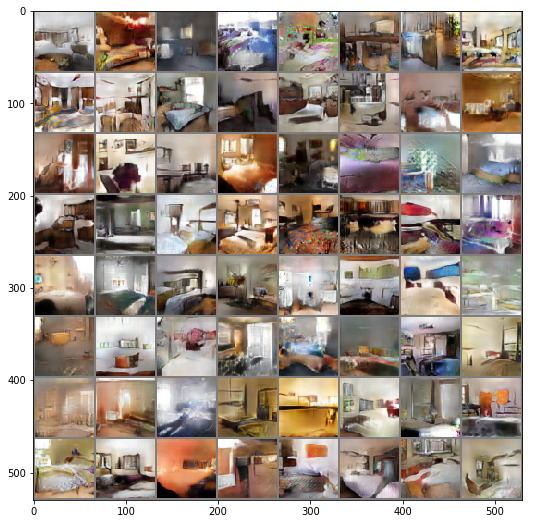

In [29]:
show(vutils.make_grid(fake), fs=(9,9))

Samples from epoch 1:

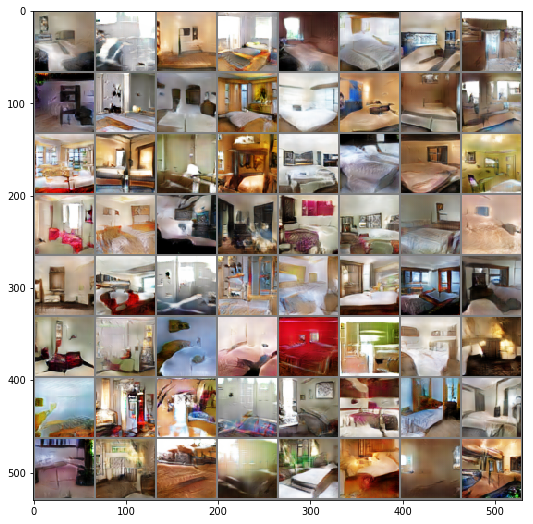

In [41]:
show(vutils.make_grid(fake), fs=(9,9))

### Real images from dataset.

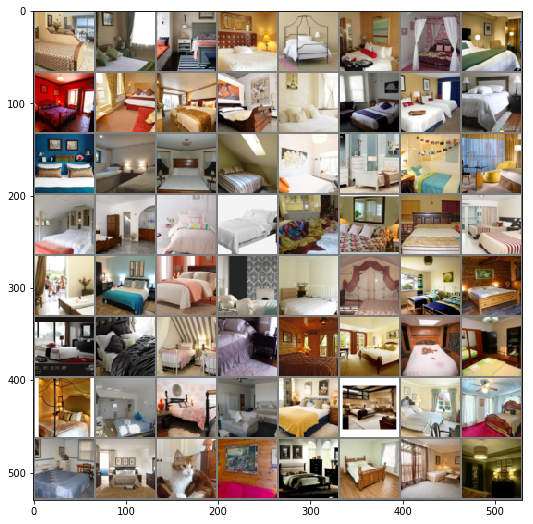

In [30]:
show(vutils.make_grid(iter(dataloader).next()[0]), fs=(9,9))